In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
file_data = '/Users/cemalarican/Desktop/THESIS/PART 3/YEAR/'
file_main_data = '/Users/cemalarican/Desktop/THESIS/PART 3/YEAR/MAIN_DATA/'

years = [2015, 2016, 2017, 2018]

# before the swap: stock1 actually equals stock2
coint_pairs = pd.read_csv('/Users/cemalarican/Desktop/THESIS/pairs_to_investigate.csv')

import sys  
sys.path.insert(0, '/Users/cemalarican/Desktop/THESIS/')

from pipeLine import Pipeline

In [13]:
data = pd.DataFrame()

# originally 239
for year in years:
    data['perf_' + str(year)] = pd.read_csv(file_data + 'pair_sim_' + str(year)+'.csv').iloc[-1]

data.drop('Unnamed: 0', inplace=True)

idx = list(data.index)

for year in years:
    d =  pd.read_csv(file_data + 'MAIN_DATA/pair_sim_'+ str(year) +'.csv').groupby('symbol')
    alphas = []
    betas = []
    sharpes = []
    maxdraw = []
    for i in range(239):
        
        stock_alpha = d.get_group(idx[i]).alpha.iloc[-1]
        stock_beta = d.get_group(idx[i]).beta.iloc[-1]
        stock_sharpe = d.get_group(idx[i]).sharpe.iloc[-1]
        stock_maxdraw = d.get_group(idx[i]).max_drawdown.iloc[-1]
        alphas.append(stock_alpha)
        betas.append(stock_beta)
        sharpes.append(stock_sharpe)

    data['alpha_' + str(year)] = alphas
    data['beta_' + str(year)] = betas
    data['sharpe_' + str(year)] = sharpes


data['STAT'] = [list(data.index)[i].split(':')[1] for i in range(len(data)) ]

for year in years:
    data['pct_'+str(year)] = (data['perf_' +str(year)]/100000) -1
    


/opt/anaconda3/envs/zipline/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (13,14,16,19,35,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
pnl_data_15 = pd.DataFrame()
pnl_data_16 = pd.DataFrame()
pnl_data_17 = pd.DataFrame()
pnl_data_18 = pd.DataFrame()
tickers = list(data.index)

def get_pnl(year, dbase, year_base):
    d = pd.read_csv(file_main_data + 'pair_sim_' + str(year) + '.csv')
    dg = d.groupby('symbol')
    tickers = list(data.index)
    for i in range(len(dbase)):
        year_base[tickers[i]] = dg.get_group(tickers[i]).pnl.reset_index(drop=True)
    return year_base

def get_pnl_list(pnl_data, yr):
    list_of_pnl = []
    for i in range(len(coint_pairs)):
        tick = pd.DataFrame()
        tick['data'] = pnl_data[tickers[i]]
        tick['pos'] = pnl_data[tickers[i]] > 0

        t = tick.groupby('pos').get_group(False)
        try:
            tt = tick.groupby('pos').get_group(True)
        except KeyError:
            pass

        t_len = len(t)
        tt_len = len(tt)

        t_mean = t['data'].mean()
        tt_mean = tt['data'].mean()

        whole_avg = pnl_data[tickers[i]].mean()

        r = (tickers[i], t_len, tt_len, t_mean, tt_mean, whole_avg, data['perf_'+str(yr)].iloc[i])
        list_of_pnl.append(r)

    return list_of_pnl        


def make_df_pnl(pnl_list, yr):
    df = pd.DataFrame(data=pnl_list, columns=['pair', 'no_loss', 'no_win', 'avg_loss', 'avg_win', 'whole_avg', 'perf_'+str(yr)])
    df.set_index('pair', inplace=True)
    s = list(df.index)
    df['stat'] = [s[i].split(':')[1] for i in range(len(s))]
    df['pos_avg'] = df.whole_avg > 0
    df['win'] = df['perf_'+ str(yr)] > 100000
    tot_days = df['no_loss'] + df['no_win']
    df['loss_percent'] = round(df['no_loss']/tot_days, 2)
    df['win_percent'] = round(df['no_win']/tot_days, 2)
    
    
    return df[df['perf_'+str(yr)] != 100000]


pnl_15 = get_pnl(2015, data, pnl_data_15)
pnl_16 = get_pnl(2016, data, pnl_data_16)
pnl_17 = get_pnl(2017, data, pnl_data_17)
pnl_18 = get_pnl(2018, data, pnl_data_18)

list_15 = get_pnl_list(pnl_15, 2015)
list_16 = get_pnl_list(pnl_16, 2016)
list_17 = get_pnl_list(pnl_17, 2017)
list_18 = get_pnl_list(pnl_18, 2018)

df_15 = make_df_pnl(list_15, 2015)
df_16 = make_df_pnl(list_16, 2016)
df_17 = make_df_pnl(list_17, 2017)
df_18 = make_df_pnl(list_18, 2018)

def get_tables(data, year):
    
    cols = ['no_loss', 'no_win', 'avg_loss','avg_win', 'whole_avg', 'perf_' + str(year), 'loss_percent', 'win_percent']
    
    avg_list = [list(round(data[cols].mean(), 2).reset_index(drop=True))[i] for i in range(8)]
    
    stat_list = list(round(data.groupby('stat').get_group('STAT')[cols].mean(), 2))
    
    nstat_list = list(round(data.groupby('stat').get_group('NON-STAT')[cols].mean(), 2))
    
    stat = data.groupby('stat').get_group('STAT')
    
    win_stat = list(round(stat.groupby('win').get_group(True)[cols].mean(), 2))
    
    nstat = data.groupby('stat').get_group('NON-STAT')
    
    win_nstat = list(round(nstat.groupby('win').get_group(True)[cols].mean(), 2))
    
    df_list = [avg_list, stat_list, nstat_list, win_stat, win_nstat]
    
    index = ['avg', 'avg stat', 'avg non-stat', 'avg winning stat', 'avg winning non-stat']
    
    list_to_df =  pd.DataFrame(data=df_list, columns=cols, index=index)
    list_to_df.to_latex(buf=file_data + str(year)+' daily returns.txt', index=True)
    print(list_to_df)
    

get_tables(df_18, 2018)
get_tables(df_17, 2017)
get_tables(df_16, 2016)
get_tables(df_15, 2015)

/opt/anaconda3/envs/zipline/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (13,14,16,19,35,42) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


                      no_loss  no_win  avg_loss  avg_win  whole_avg  \
avg                    642.53  365.03  -2209.63  2735.80     -65.43   
avg stat               639.51  368.73  -2830.98  3402.24     -83.96   
avg non-stat           649.37  356.63   -801.24  1225.18     -23.42   
avg winning stat       598.94  407.06  -1397.83  2383.81     117.83   
avg winning non-stat   659.62  346.38   -364.93  1278.20      62.51   

                      perf_2018  loss_percent  win_percent  
avg                    34176.21          0.64         0.36  
avg stat               15532.54          0.63         0.37  
avg non-stat           76435.20          0.64         0.36  
avg winning stat      218539.89          0.60         0.40  
avg winning non-stat  162883.97          0.65         0.35  
                      no_loss  no_win  avg_loss  avg_win  whole_avg  \
avg                    493.98  261.77  -1283.74  1654.73     -48.91   
avg stat               493.74  262.35  -1608.09  1967.75     -74.

In [15]:
data = data[data['perf_2018'] != 100000]

In [16]:
for year in years:
    
    def get_beta(year, dbase):
        d = pd.read_csv(file_main_data + 'pair_sim_' + str(year) + '.csv')
        dg = d.groupby('symbol')
        betas = []
        tickers = list(dbase.index)
        for i in range(len(dbase)):
            betas.append(dg.get_group(tickers[i]).beta.iloc[-1])

        return betas
    
    def get_alpha(year, dbase):
        d = pd.read_csv(file_main_data + 'pair_sim_' + str(year) + '.csv')
        dg = d.groupby('symbol')
        alphas = []
        tickers = list(dbase.index)
        for i in range(len(dbase)):
            alphas.append(dg.get_group(tickers[i]).alpha.iloc[-1])

        return alphas
    
    def get_sharpe(year, dbase):
        d = pd.read_csv(file_main_data + 'pair_sim_' + str(year) + '.csv')
        dg = d.groupby('symbol')
        sharpes = []
        tickers = list(dbase.index)
        for i in range(len(dbase)):
            sharpes.append(dg.get_group(tickers[i]).sharpe.iloc[-1])

        return sharpes
    
    def get_maxdraw(year, dbase):
        d = pd.read_csv(file_main_data + 'pair_sim_' + str(year) + '.csv')
        dg = d.groupby('symbol')
        maxes = []
        tickers = list(dbase.index)
        for i in range(len(dbase)):
            maxes.append(dg.get_group(tickers[i]).max_drawdown.iloc[-1])
        return maxes

    data['beta_'+str(year)] = get_beta(year, data)
    data['alpha_'+str(year)] = get_alpha(year, data)
    data['sharpe_'+str(year)] = get_sharpe(year, data)
    data['maxdraw_'+str(year)] = get_maxdraw(year, data)


/opt/anaconda3/envs/zipline/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (13,14,16,19,35,42) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [17]:
data

perf_2015    perf_2016 perf_2017    perf_2018  \
MZZ vs SMDD:NON-STAT     101643      38673.4   42249.8      40764.2   
EDV vs UBT:NON-STAT     99721.9       100188    100522      99480.4   
IVV vs IWB:STAT         96925.5      93957.2   94827.7      95903.8   
DGL vs SGOL:STAT         100000      96844.8    102666       100734   
PHDG vs VQT:STAT         100509      99831.7    110687       102594   
IWV vs SCHB:NON-STAT     100000       102716     95084      96471.6   
IWB vs SPY:STAT         96457.1      93436.9   94883.8      94246.5   
IWB vs SSO:STAT          102238        97315   82195.5      92044.1   
CURE vs RXL:STAT          96224      94215.7    111612       114697   
EUSA vs VV:STAT         94641.8 -1.04004e+06    468796 -4.13615e+06   
PHYS vs SGOL:NON-STAT    100902       100289     99462      99217.8   
FXP vs YANG:NON-STAT     266988       698622    698622       698622   
SCHB vs VTI:NON-STAT     100000       100571   92729.1      95022.9   
DGL vs GLD:STAT          100000       101819   95856.1      96563.6   
DLN vs VYM:NON-STAT     99248.5      98649.6   99908.3       100336   
FUTY vs XLU:NON-STAT    98147.7      98289.1    100885       101821   
FXY vs YCL:STAT          100318       488602    555436       637135   
VPU vs XLU:NON-STAT      101657       100032   95531.5      93318.2   
GLD vs PHYS:STAT         115743      91261.2   82016.1      82744.1   
SCHG vs VOOG:STAT        100206        97965   88821.3      88345.8   
SCHB vs VONE:NON-STAT   99968.9        98050    104480       104653   
PGF vs PGX:STAT         99702.3      99506.6   98523.8      98180.3   
DOG vs DXD:STAT          100000      99029.6    118153       119303   
SBND vs TTT:STAT        86114.3      94189.8   71464.4      75590.6   
DNO vs DTO:NON-STAT      115657      96779.6    114255       156375   
ITOT vs VOO:STAT        95091.9       113910    128824       125643   
IWB vs SCHB:NON-STAT    98219.8      95633.1    104023       104030   
SSO vs VOO:STAT          100390      99638.5   94143.7      94247.1   
IWL vs MGC:STAT         97101.5      99460.7   99460.7      97521.6   
TBT vs TMV:NON-STAT     94779.3      86955.9   86955.9      81590.4   
...                         ...          ...       ...          ...   
NLOK vs SYMC:STAT       99855.5       101615    106756      99585.2   
VISL vs XGTI:STAT       47685.8       678660    678660       678661   
DBI vs DSW:NON-STAT     99383.1      99323.1   99258.5      99579.5   
PXLG vs SPGP:STAT        100000      99767.8   99768.2      99767.9   
VCO vs VCOYY:STAT         96379      90122.2   86908.1      83658.4   
NVLN vs NVLNF:STAT       100000      93680.1     68168      13466.1   
OXSQ vs TICC:STAT       98600.9      95692.8     95753      85277.2   
AUO vs AUOTY:STAT         99434        99137   99060.6      99063.4   
BBDC vs TCAP:STAT       98876.8      98678.1   96471.9      82683.6   
PHIO vs RXII:STAT        122809      62761.2   62594.7      62594.7   
CBS vs VIAC:NON-STAT    99803.9      99678.3   99678.1      99574.9   
CHI_2 vs QQQC:STAT      99077.8      99056.3    206799       161691   
CUR vs SNCA:STAT         100000       100000   98795.2      96828.2   
CWEN vs NYLD:STAT        100615       101316    102764       102764   
EVLV vs IMBI:STAT         73882      70988.1  -10453.4       142976   
IPCI vs IPCIF:STAT      99552.5        97854   88153.2      69821.7   
KEG vs KEGX:STAT        99153.8      98678.2   98678.2      98678.2   
KEG vs KEGXD:STAT       99153.8      98678.2   98678.2      98678.2   
MPVD vs MPVDF:STAT       107786       193690   69873.4     -34736.6   
PIPR vs PJC:STAT         100271       100446    100817       100290   
SDRL vs SDRL_:STAT      83818.5     -9101.06  -47319.9      -658067   
SPN vs SPNV:STAT        81815.4       133339   83749.4      75641.5   
SPN vs SPNVD:STAT       81815.4       133339   83749.4      75641.5   
TTS vs TTSH:STAT         100696       101018    100122       100557   
FEU vs SPEU:STAT        99937.5      99863.5  

In [18]:
data_group = data.groupby('STAT')
stat_data = data_group.get_group('STAT')
nstat_data = data_group.get_group('NON-STAT')
print('Number of stats: {}'.format(len(stat_data)))
print('Number of nstats: {}'.format(len(nstat_data)))
print('total: {}'.format(len(data)))

Number of stats: 141
Number of nstats: 61
total: 202


In [19]:
### GETTING AVERAGE RESULTS ###
average_perf = OrderedDict()
pct_mean = OrderedDict()
pct_std = OrderedDict()
alpha_mean = OrderedDict()
beta_mean = OrderedDict()
sharpe_mean = OrderedDict()
maxdraw_mean = OrderedDict()

best_5_perf = OrderedDict()
worst_5_perf = OrderedDict()

data_len = len(data)

for year in years:
    average_perf[year] = round(data['perf_' + str(year)].mean(), 2)
    pct_mean[year]     = round(data['pct_' + str(year)].mean(), 2)
    pct_std[year]      = round(data['pct_'+str(year)].std(), 2)
    alpha_mean[year]   = round(data['alpha_' + str(year)].mean(), 2)
    beta_mean[year]    = round(data['beta_' + str(year)].mean(), 2)
    sharpe_mean[year]  = round(data['sharpe_' + str(year)].mean(), 2)
    maxdraw_mean[year] = round(data['maxdraw_'+ str(year)].mean(), 2)
    
    d = pd.read_csv(file_data + '/pair_sim_' + str(year)+'.csv')
    best_idx = [data['perf_'+str(year)].sort_values()[data_len-5:data_len].index[i] for i in range(5)]
    worst_idx = [data['perf_'+str(year)].sort_values()[:5].index[i] for i in range(5)]
    
    best_5_perf[year] = [(best_idx[i], d[best_idx[i]]) for i in range(len(best_idx))]
    worst_5_perf[year] = [(worst_idx[i], d[worst_idx[i]]) for i in range(len(worst_idx))]
    
colnames = ['average portfolio value', 'average percentage change', 'average standard deviation',
            'average alpha', 'average beta', 'average sharpe ratio', 'average max drawdown']

list_of_dicts = [average_perf, pct_mean, pct_std,
                 alpha_mean, beta_mean, sharpe_mean, maxdraw_mean]

main_df = pd.DataFrame()
main_df['year'] = pd.Series(years)

for i in range(len(list_of_dicts)):
    df = pd.DataFrame(data=list(list_of_dicts[i].items()) , columns=['year', colnames[i]] )
    main_df = pd.concat([main_df, df[colnames[i]]], axis=1)
main_df.to_latex(buf=file_data+'average-perf.txt', index=False)


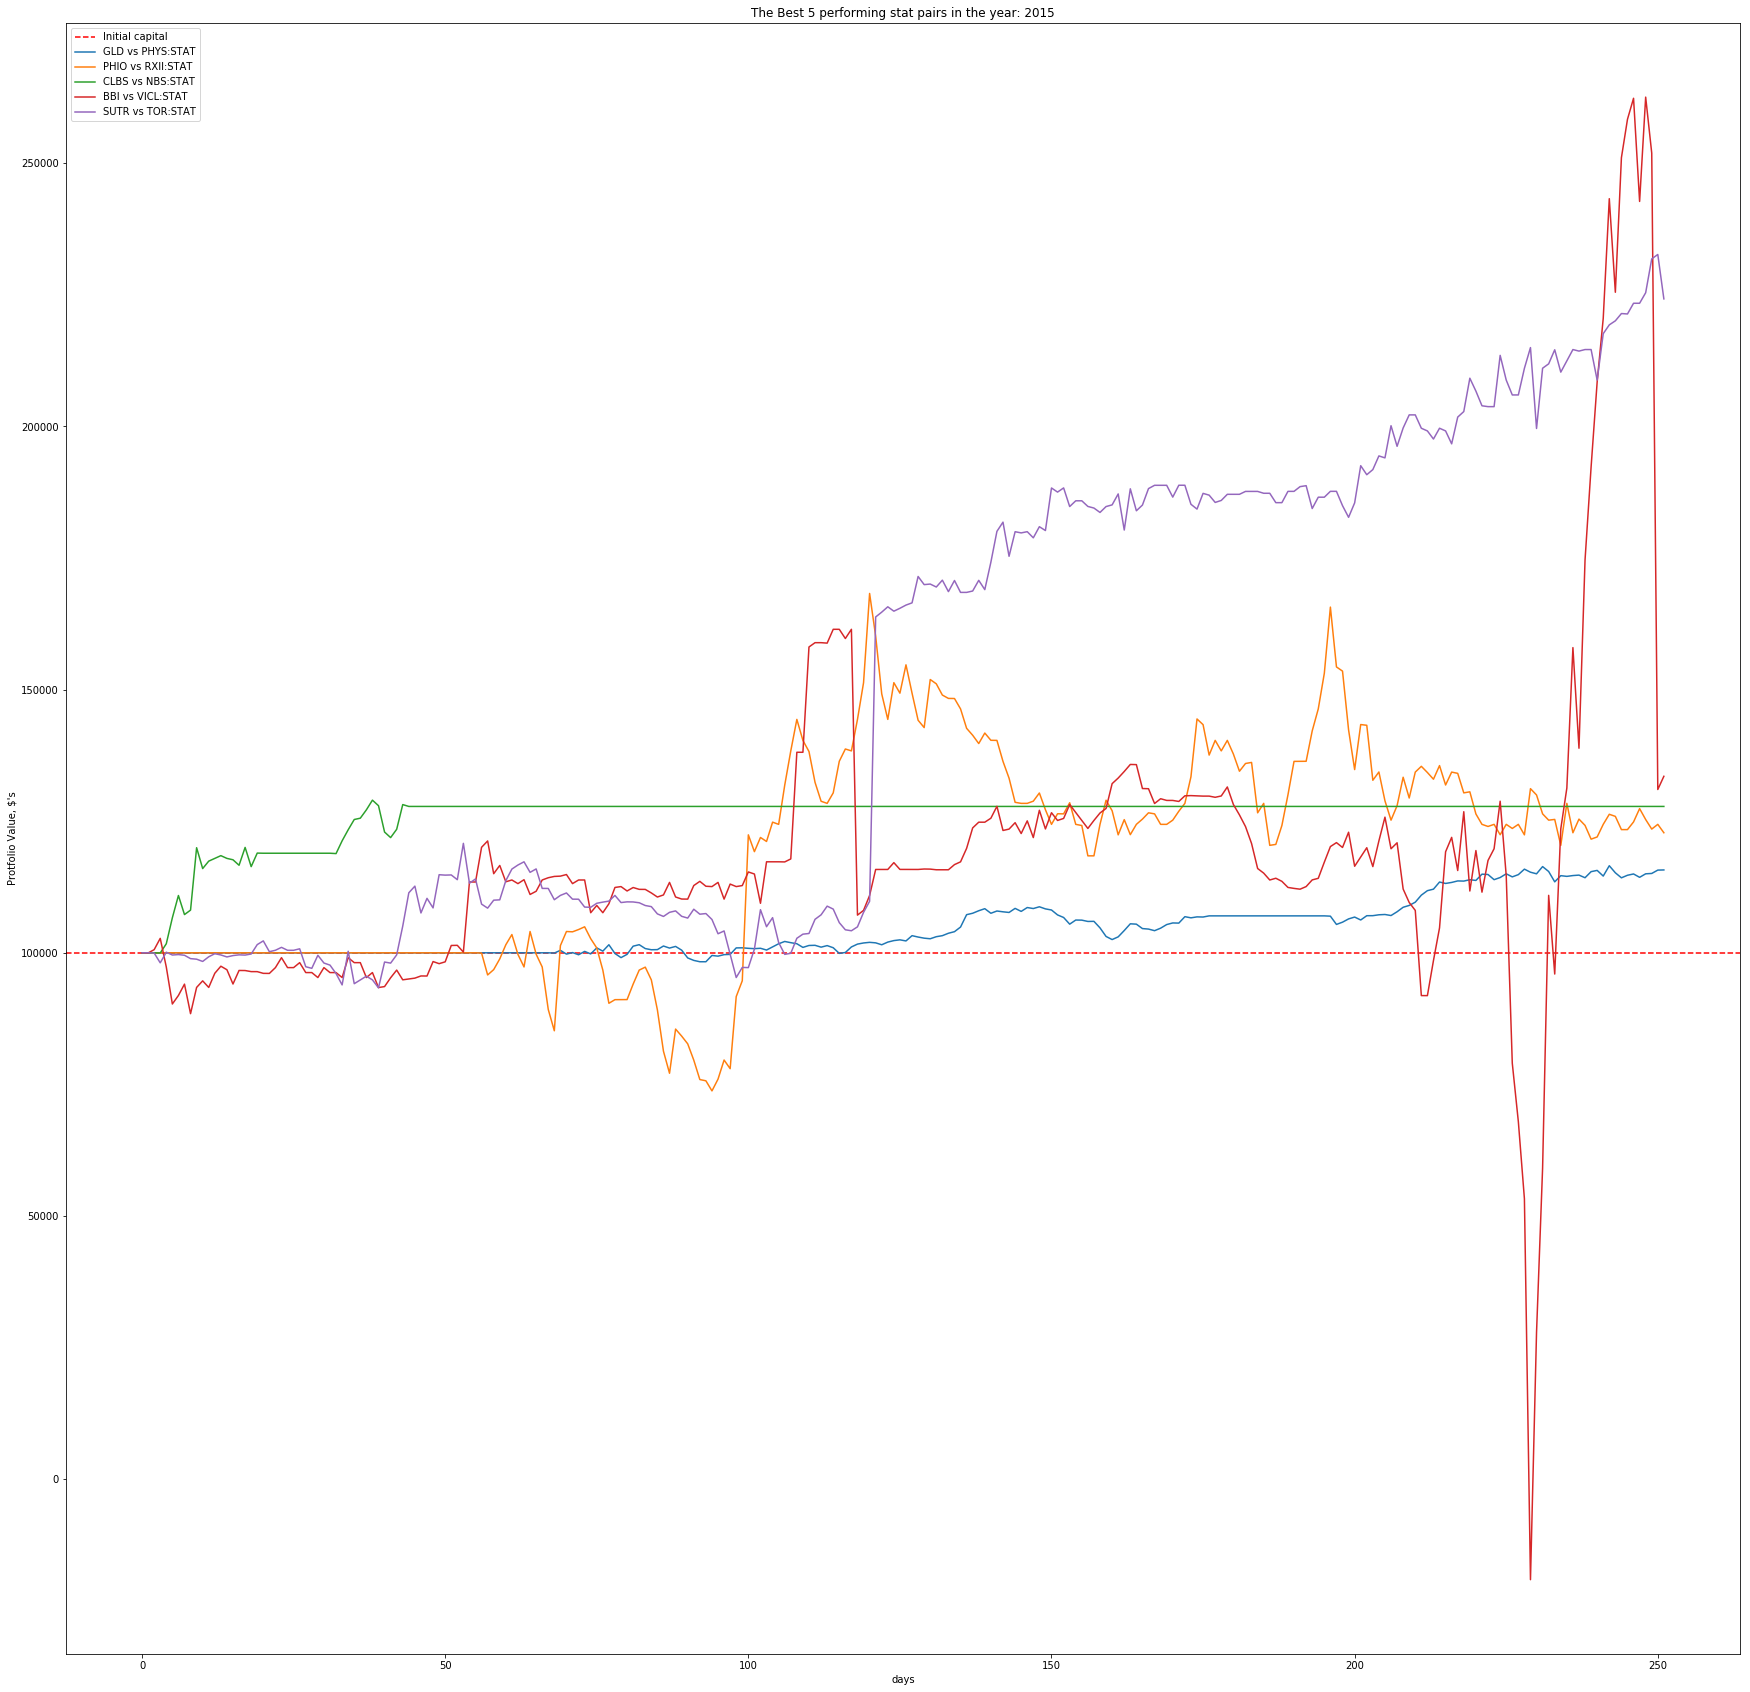

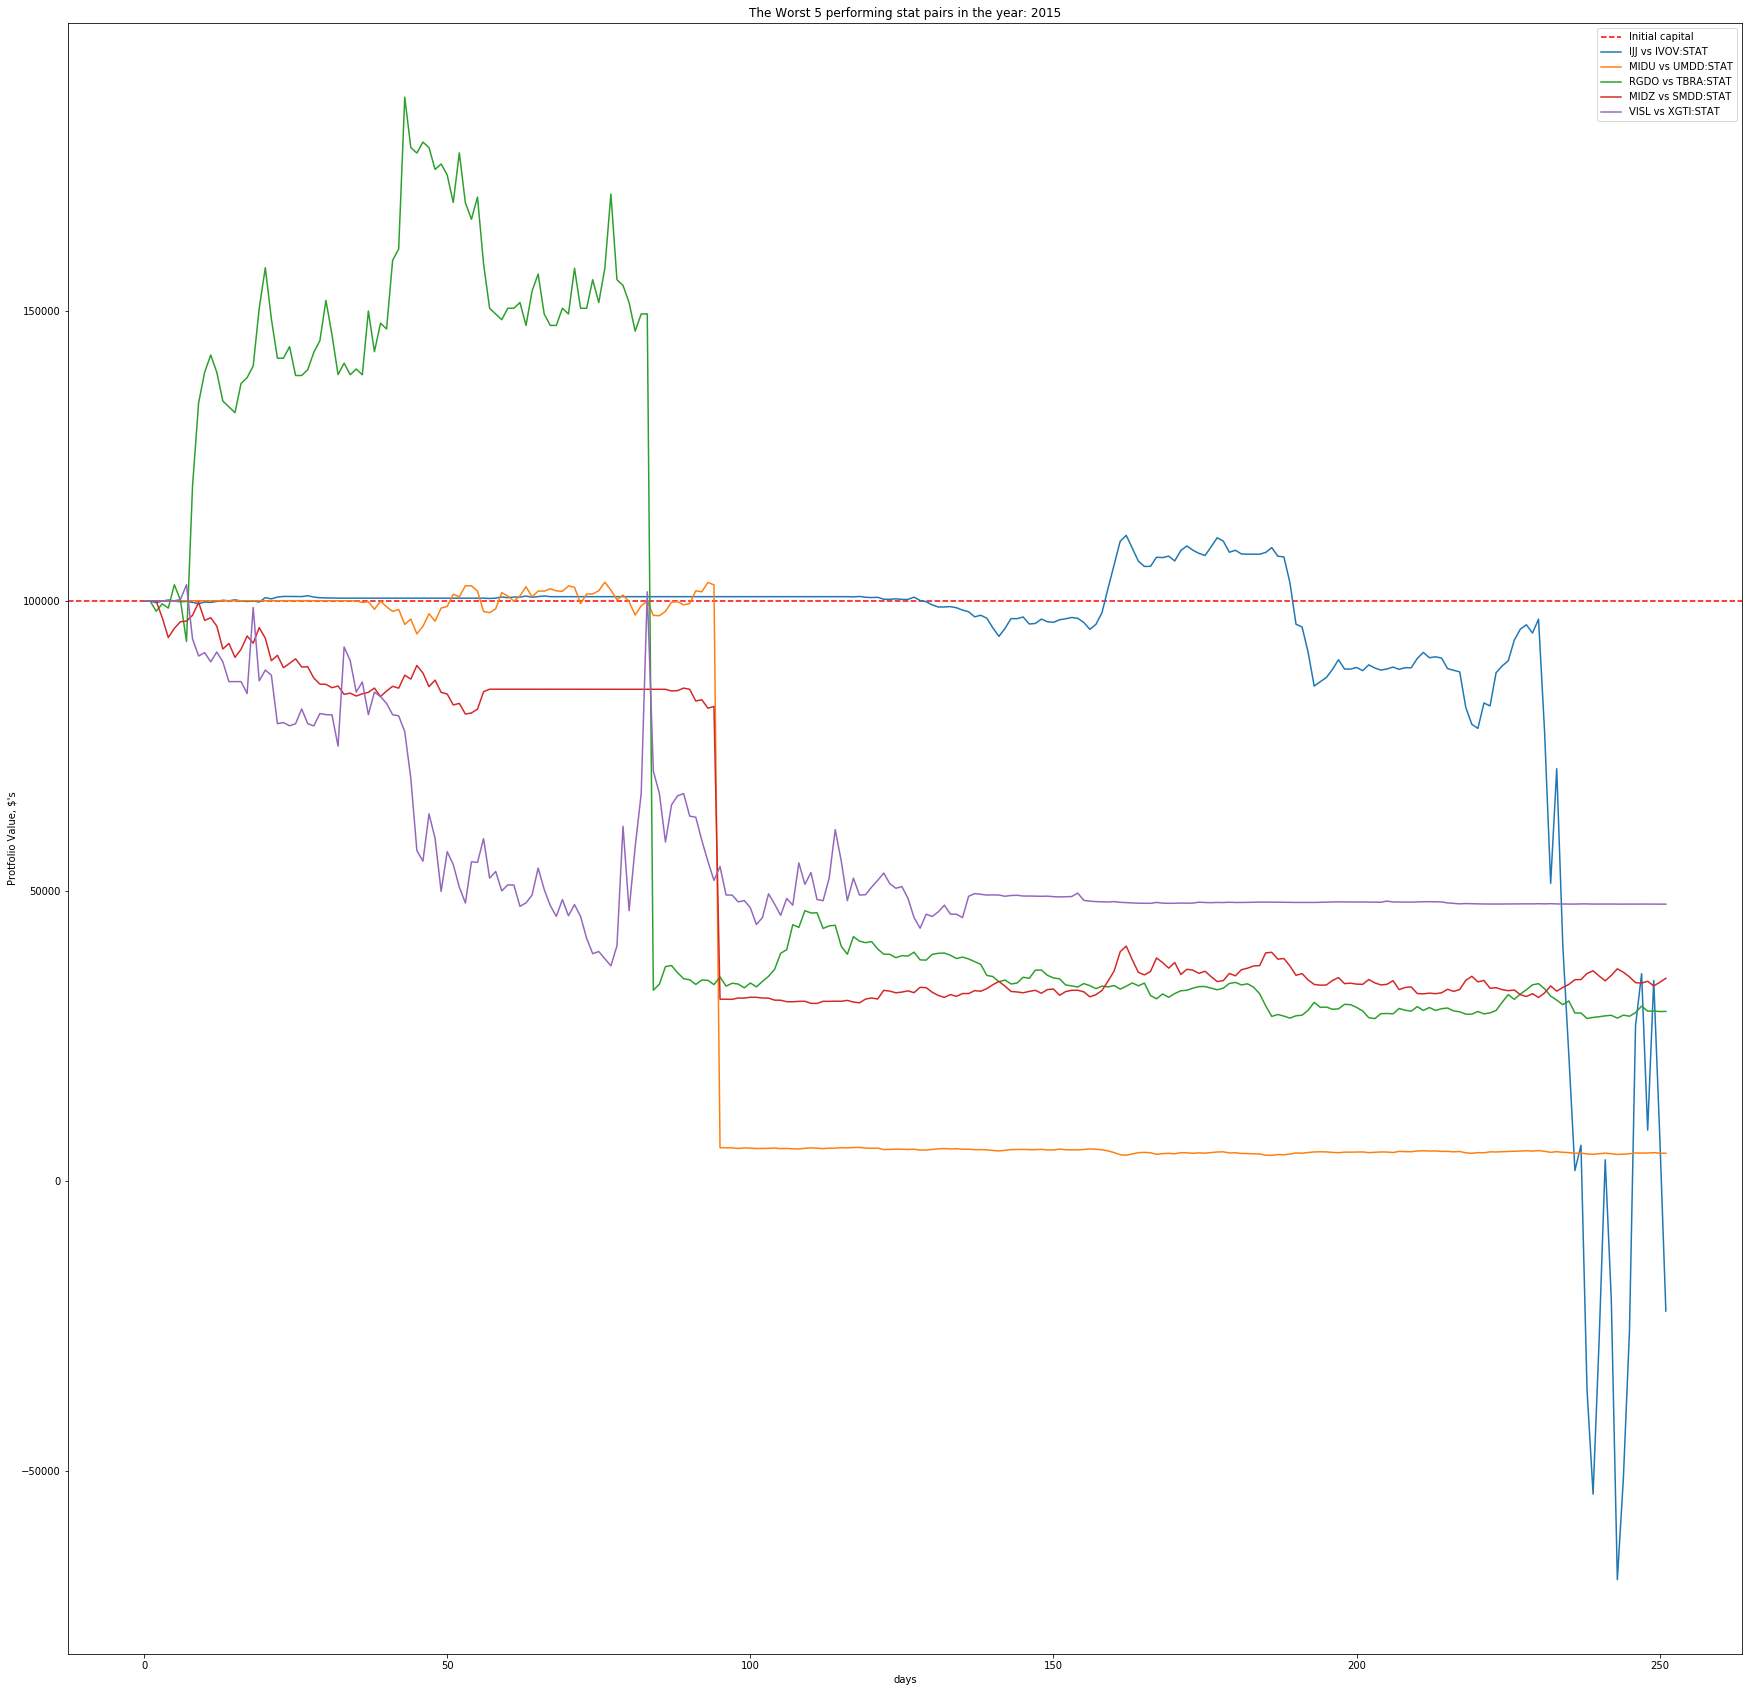

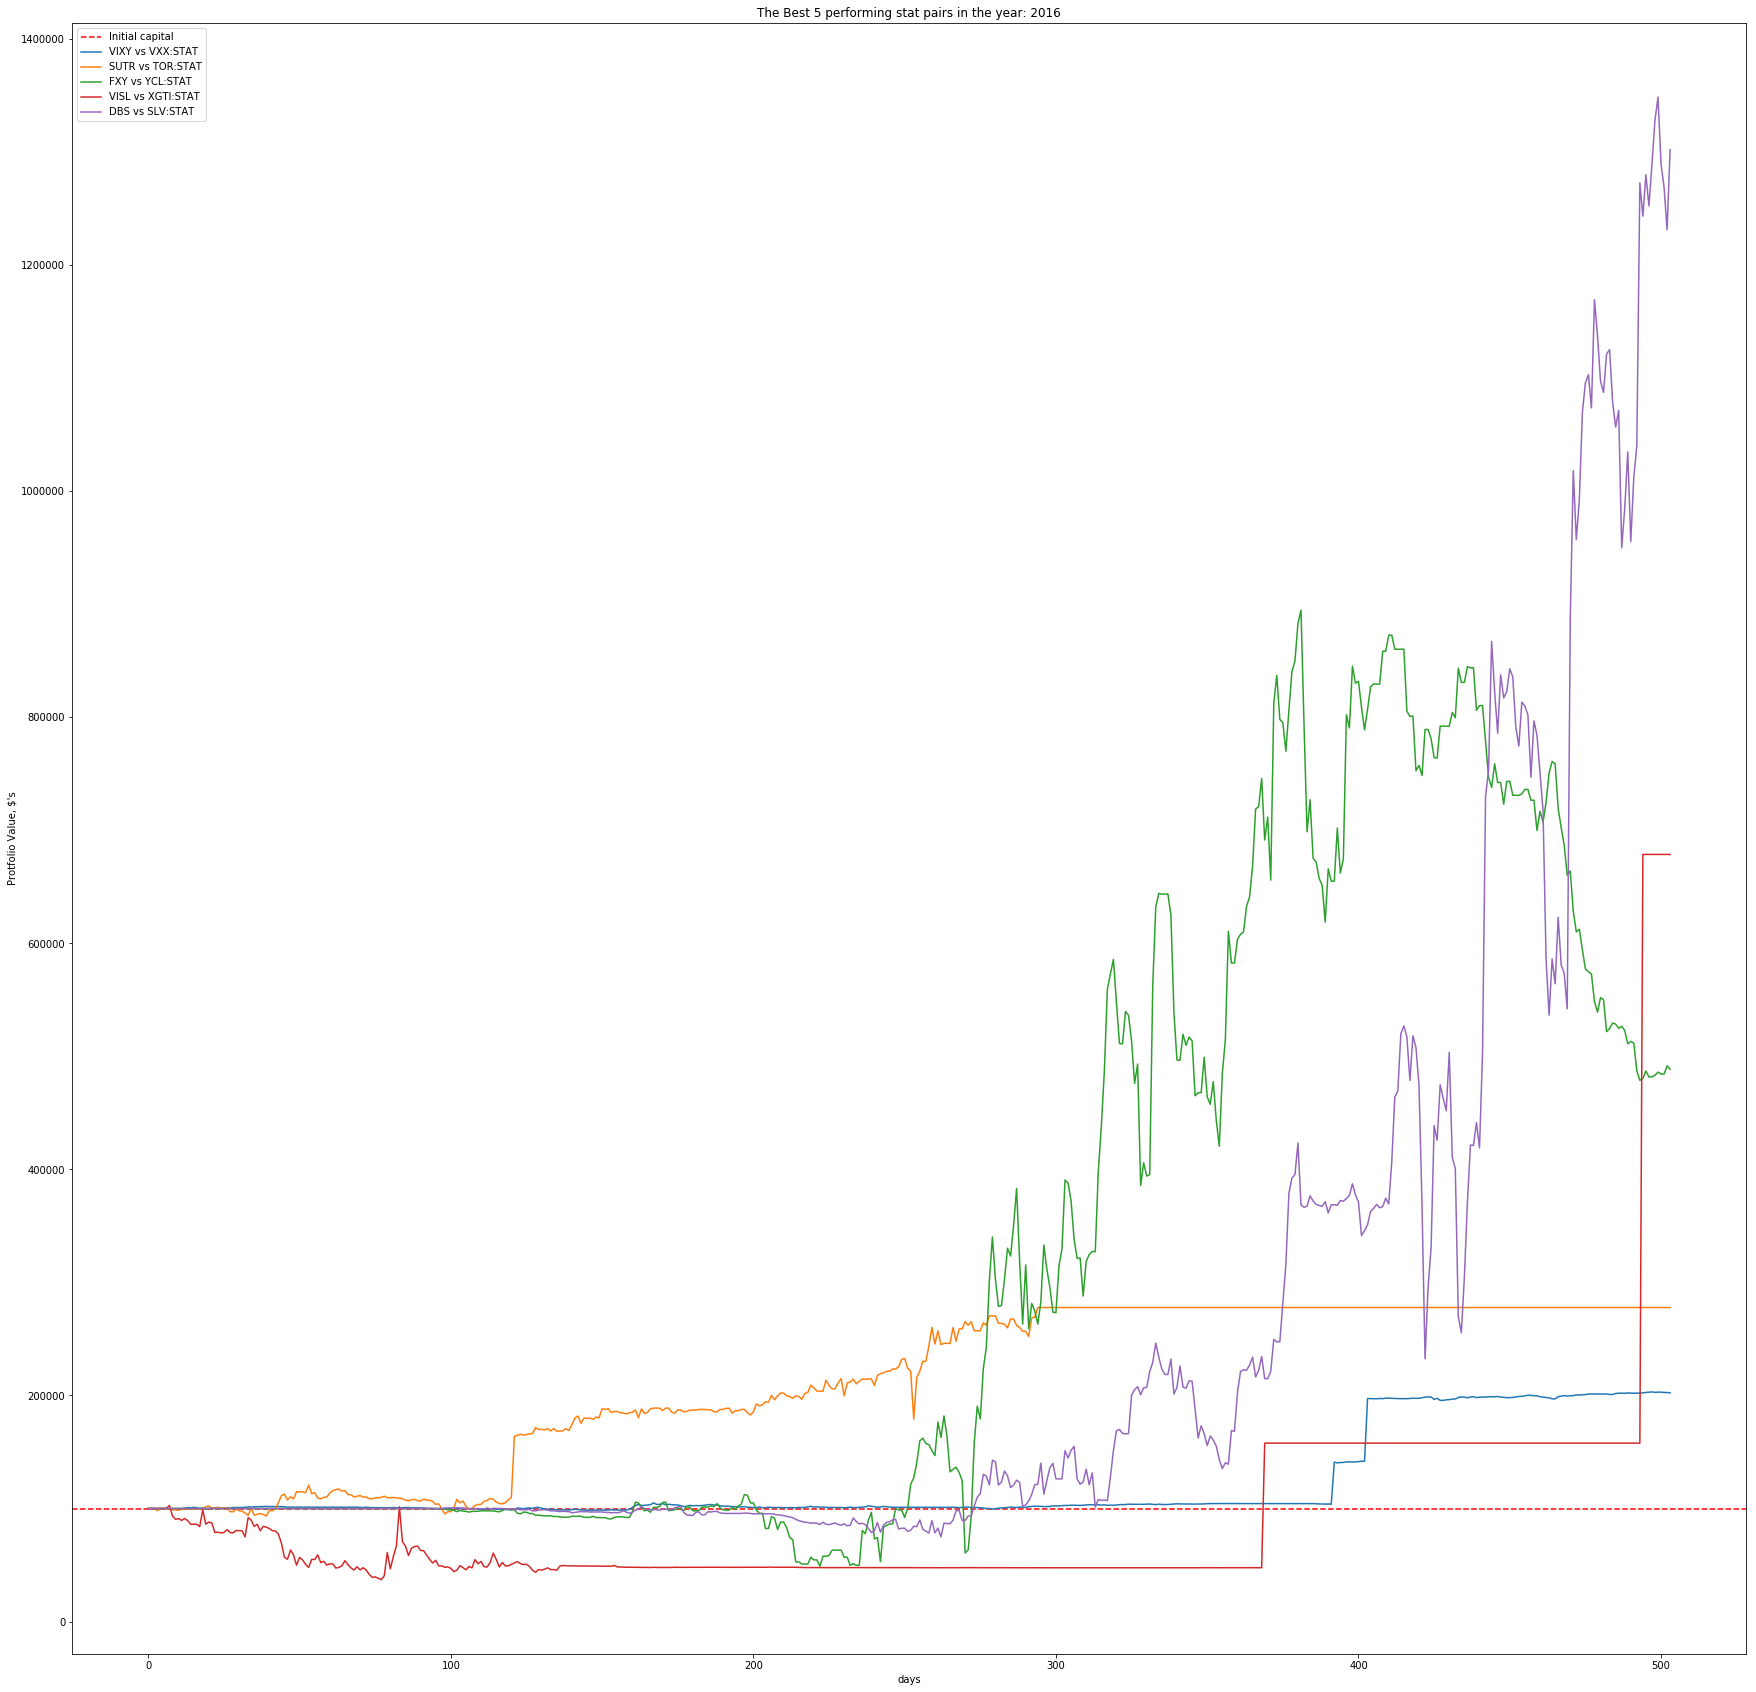

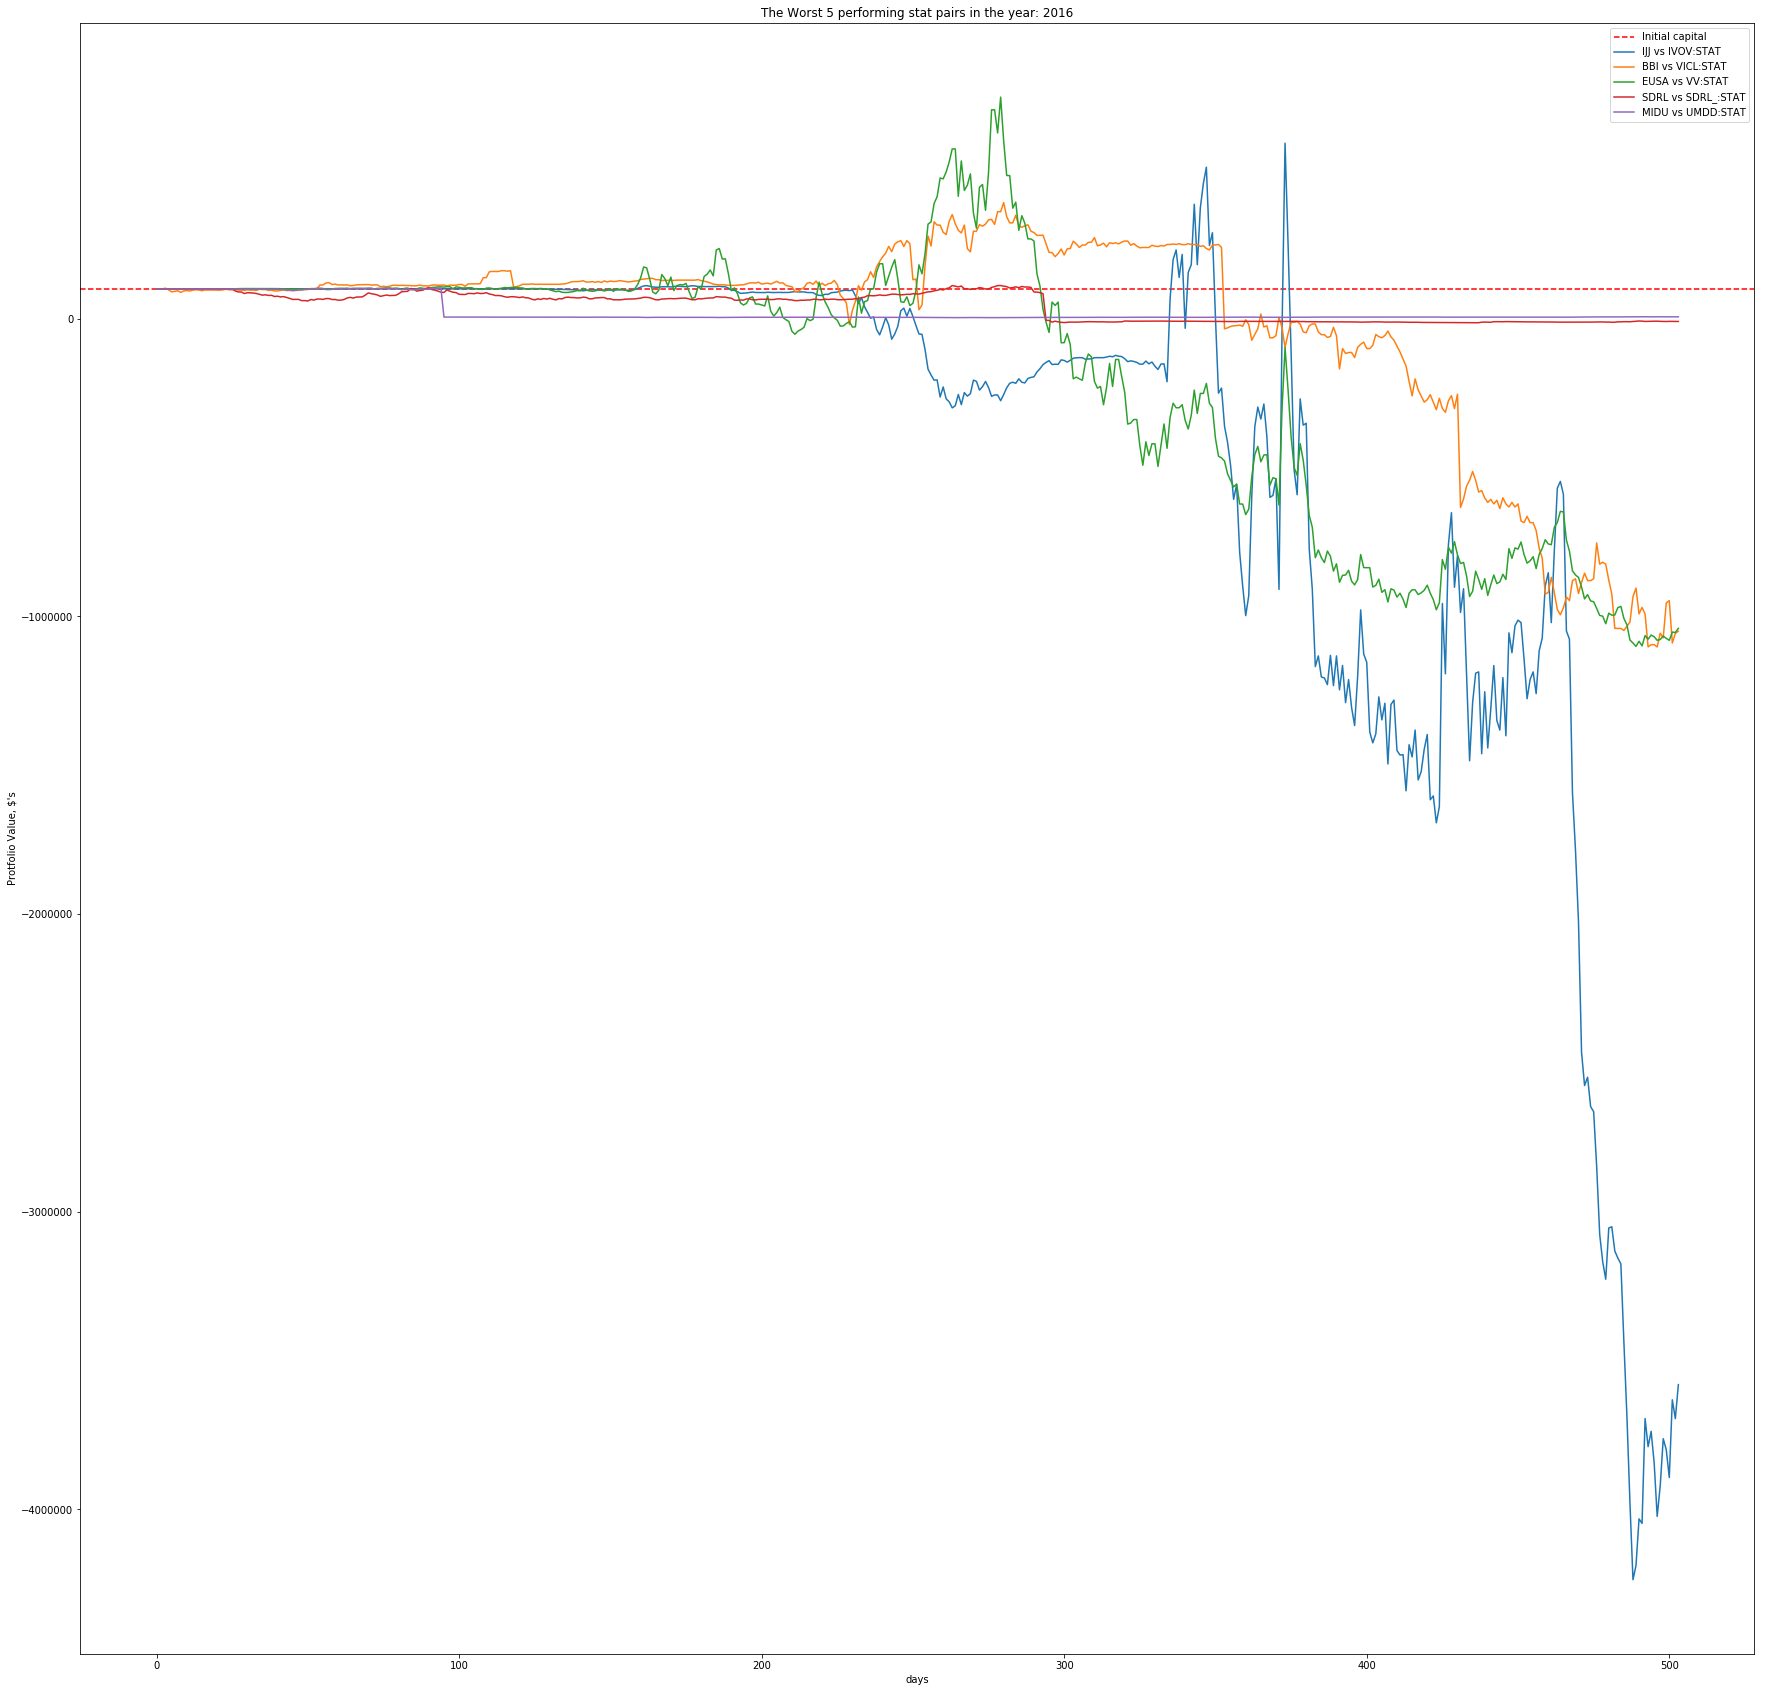

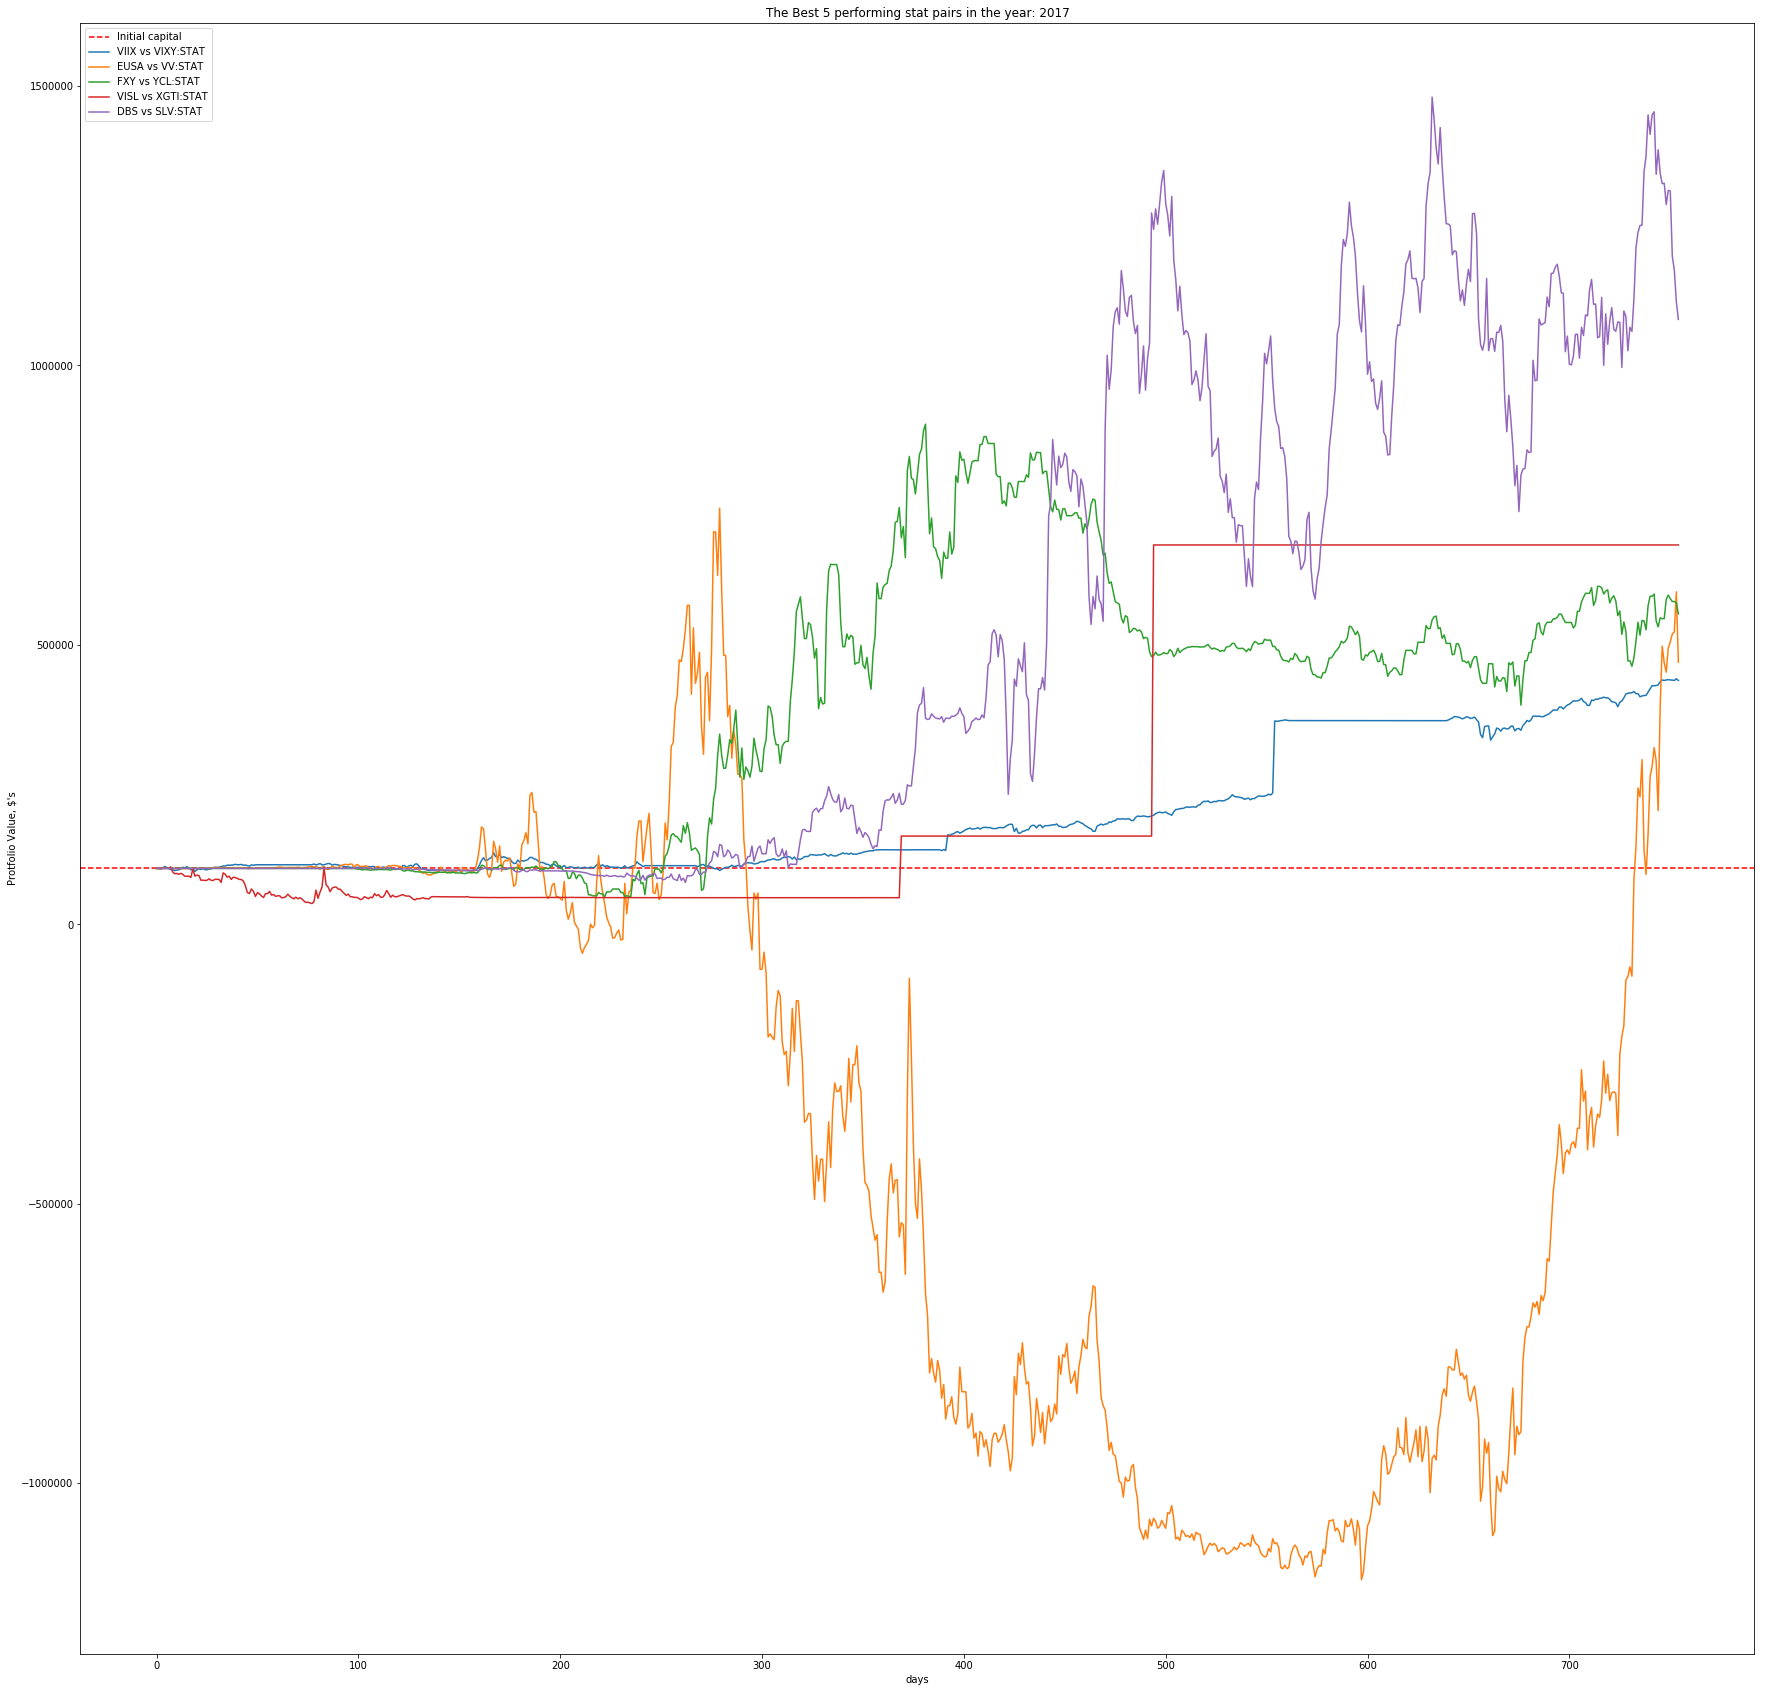

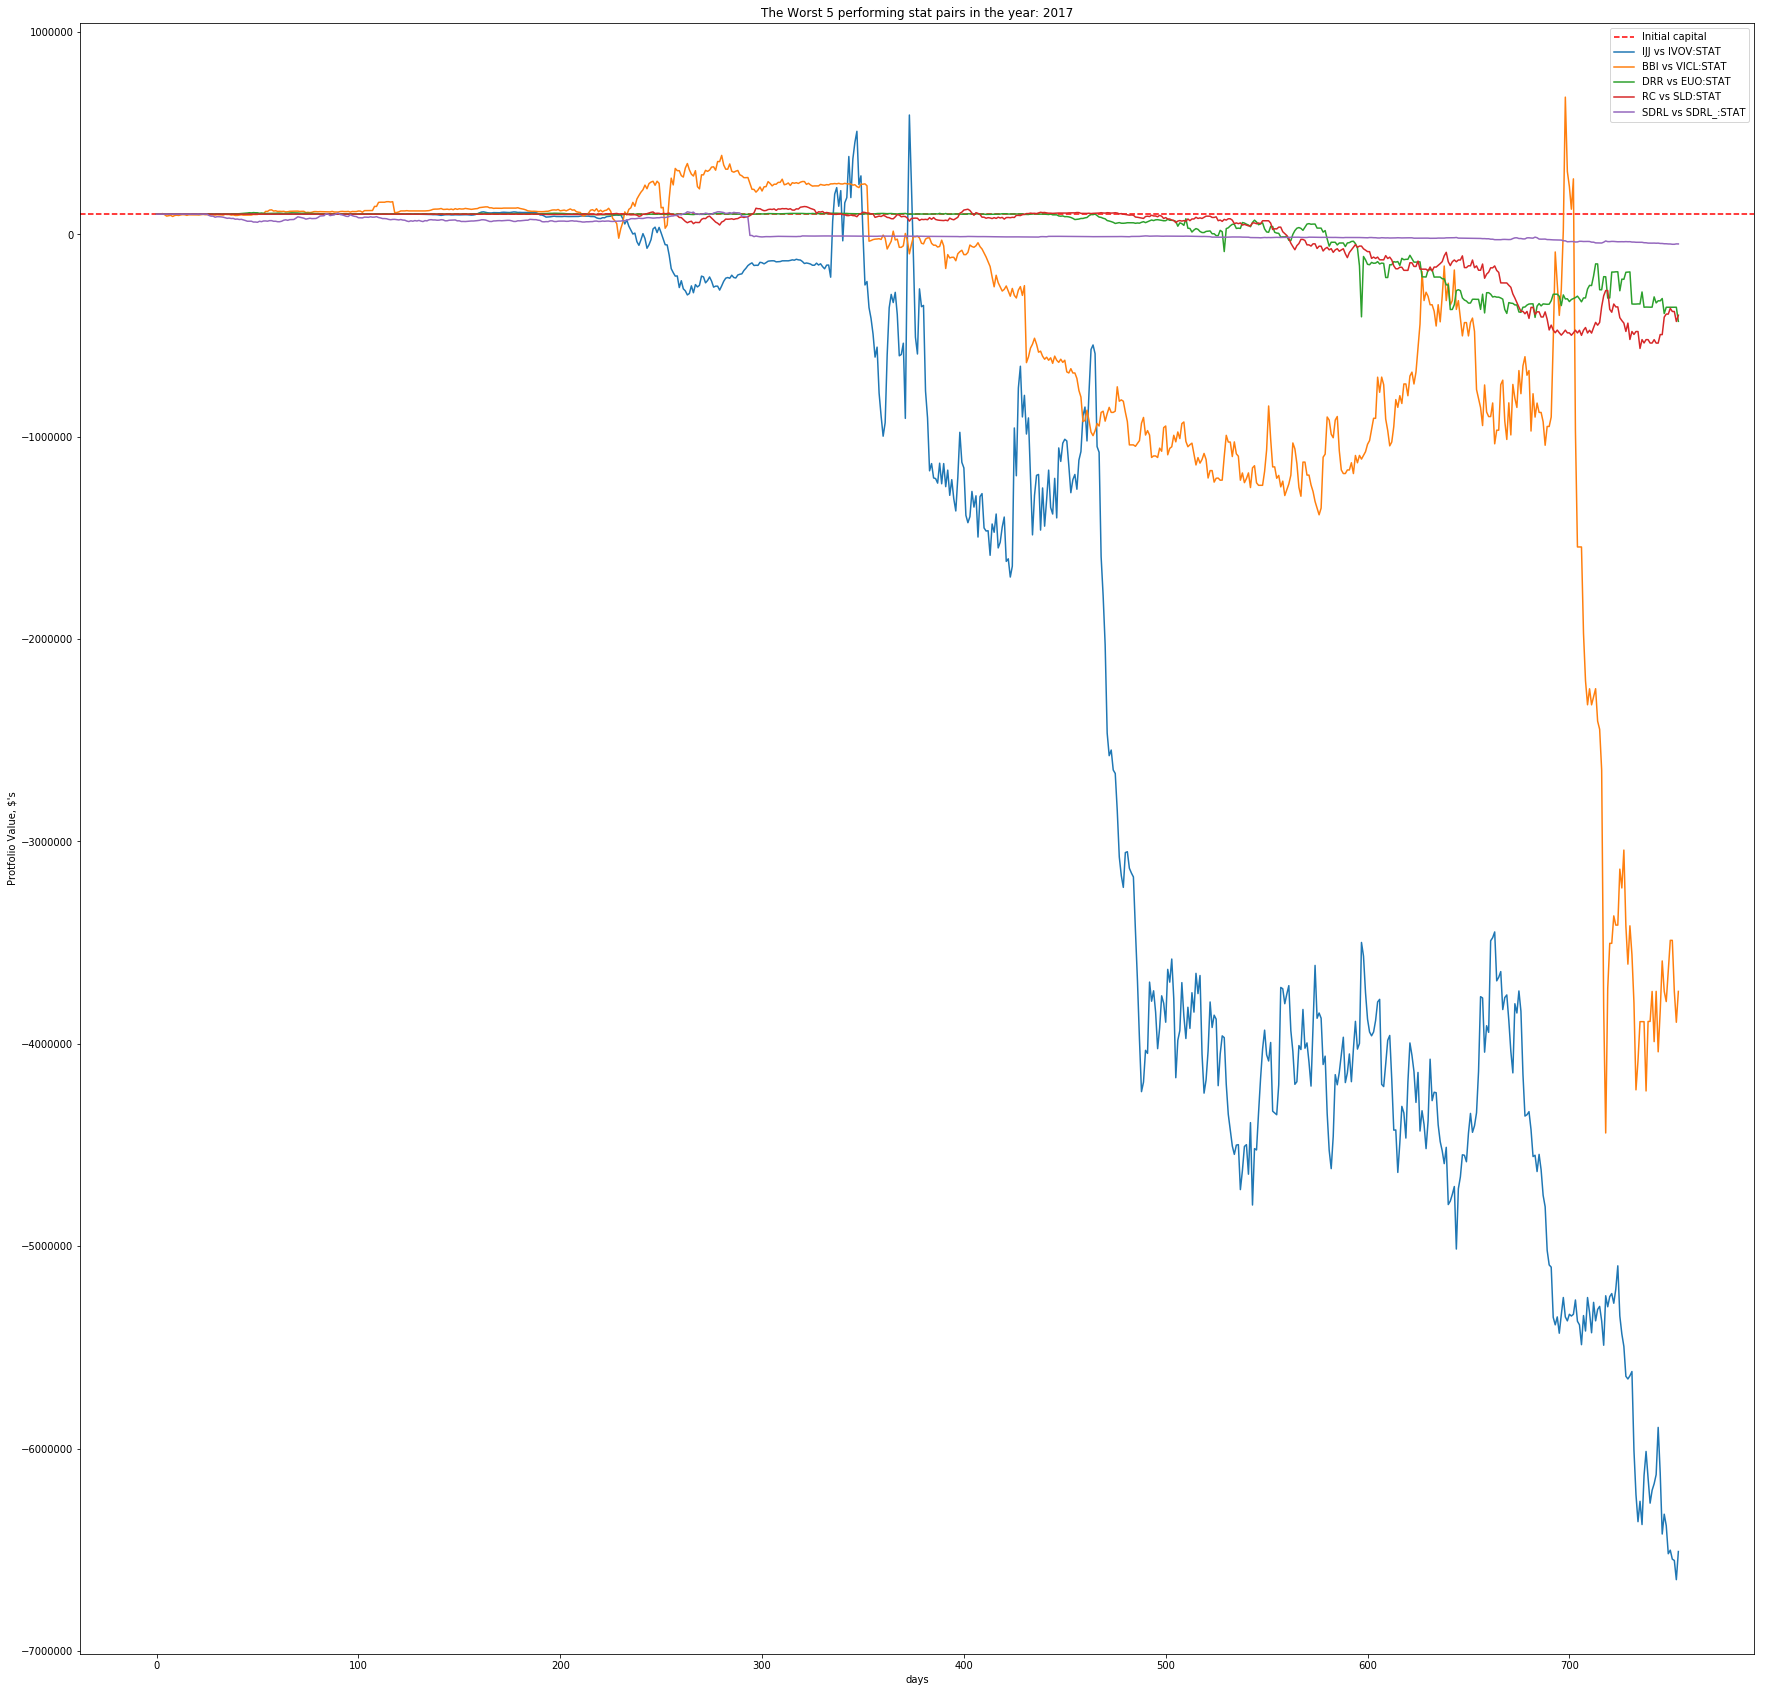

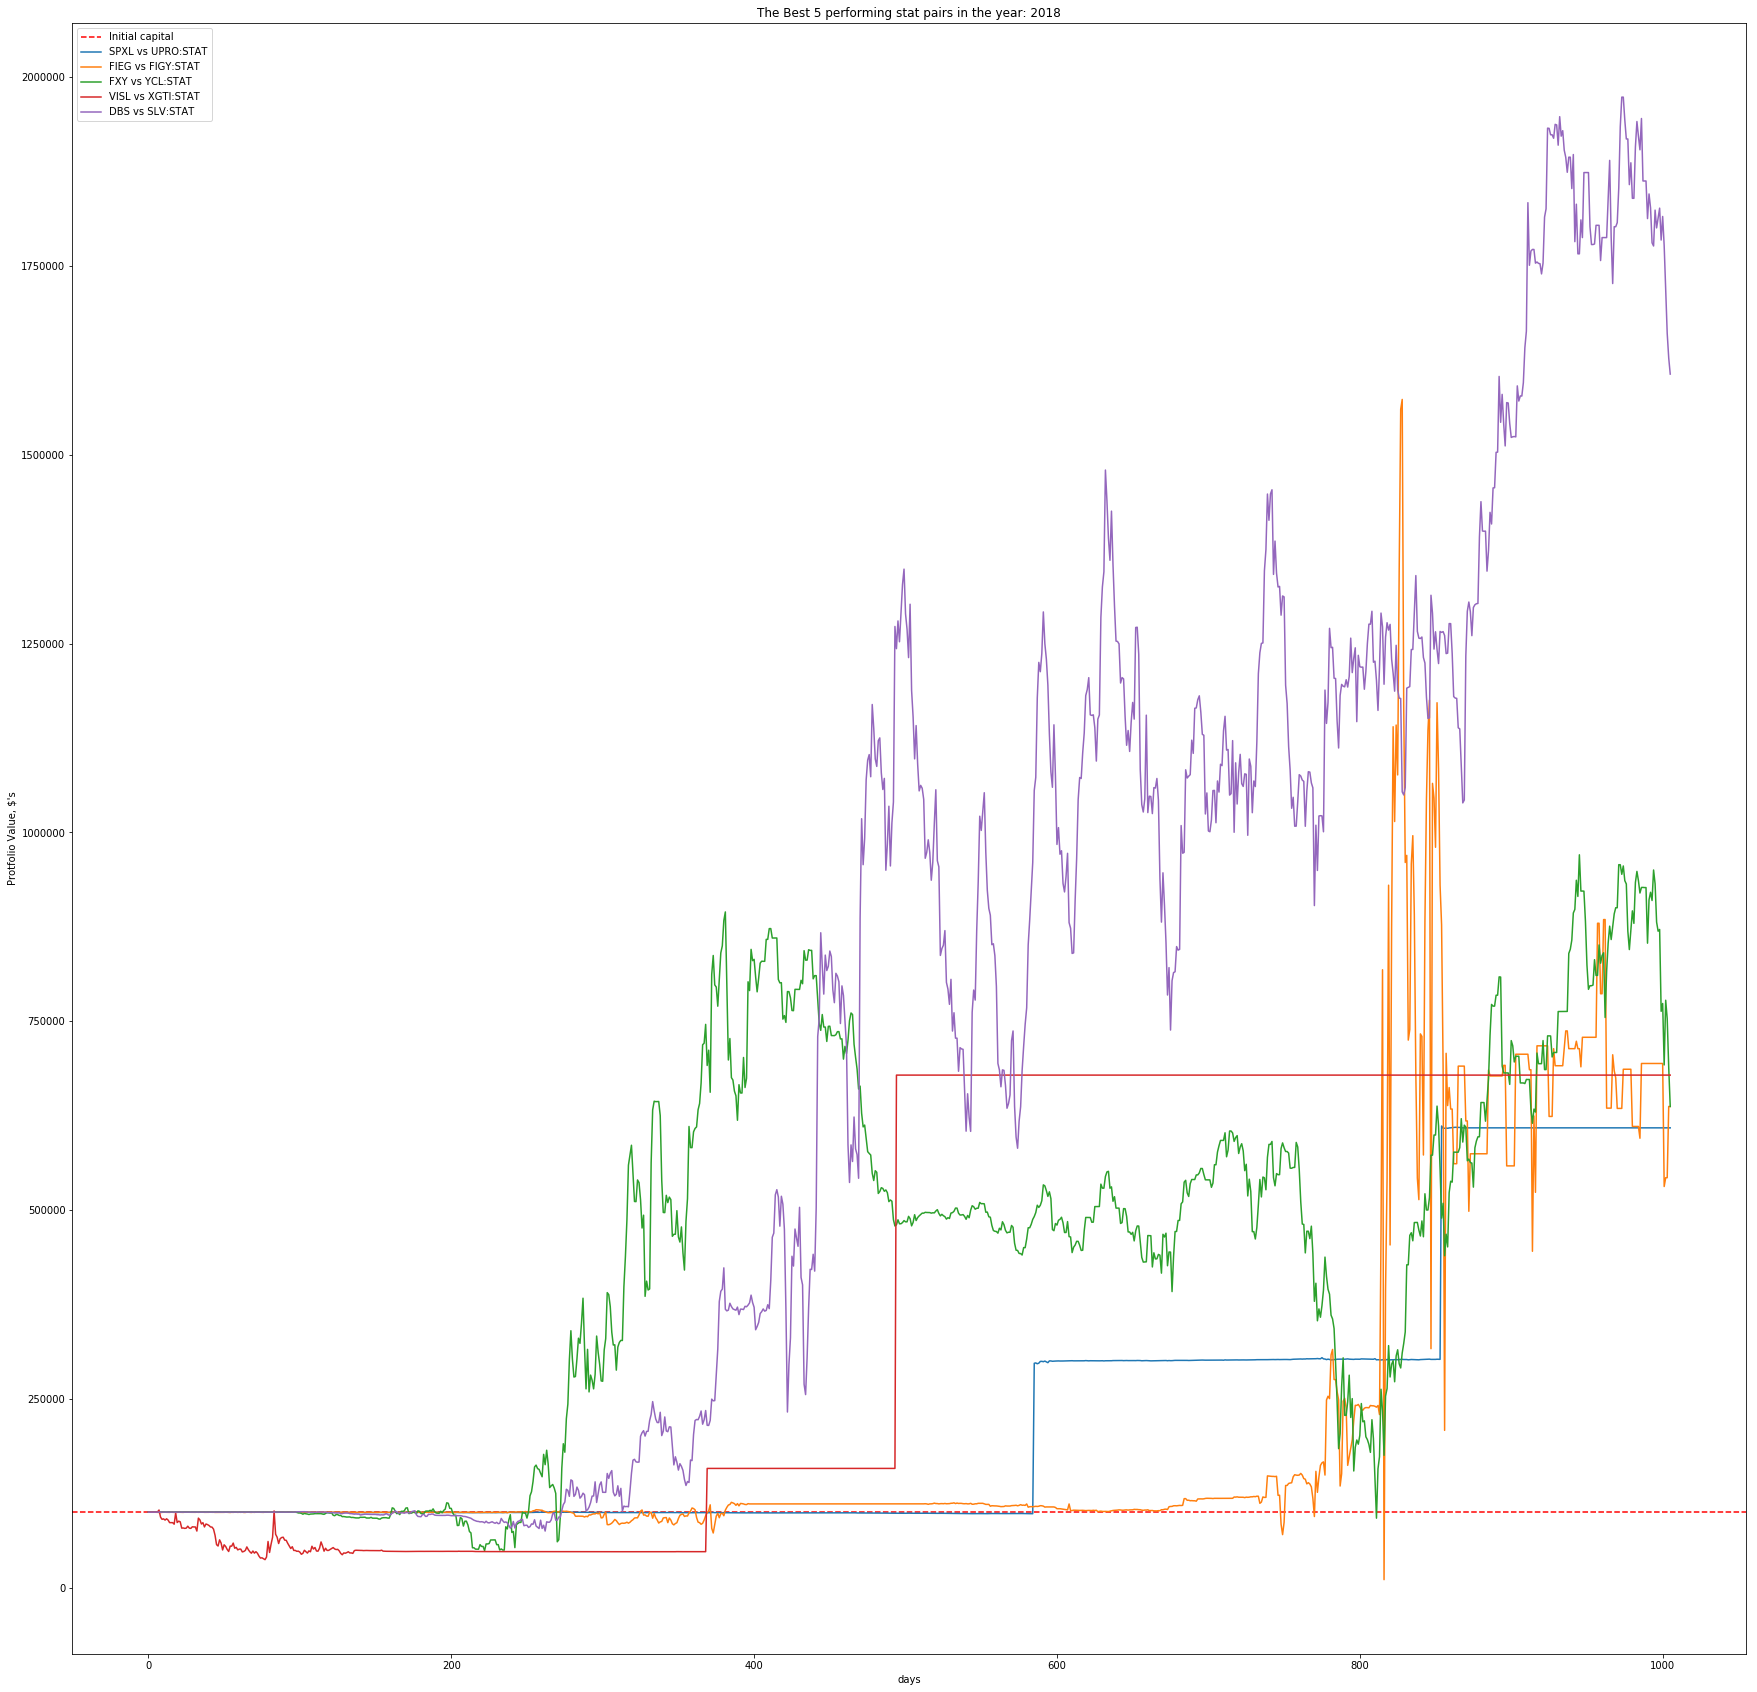

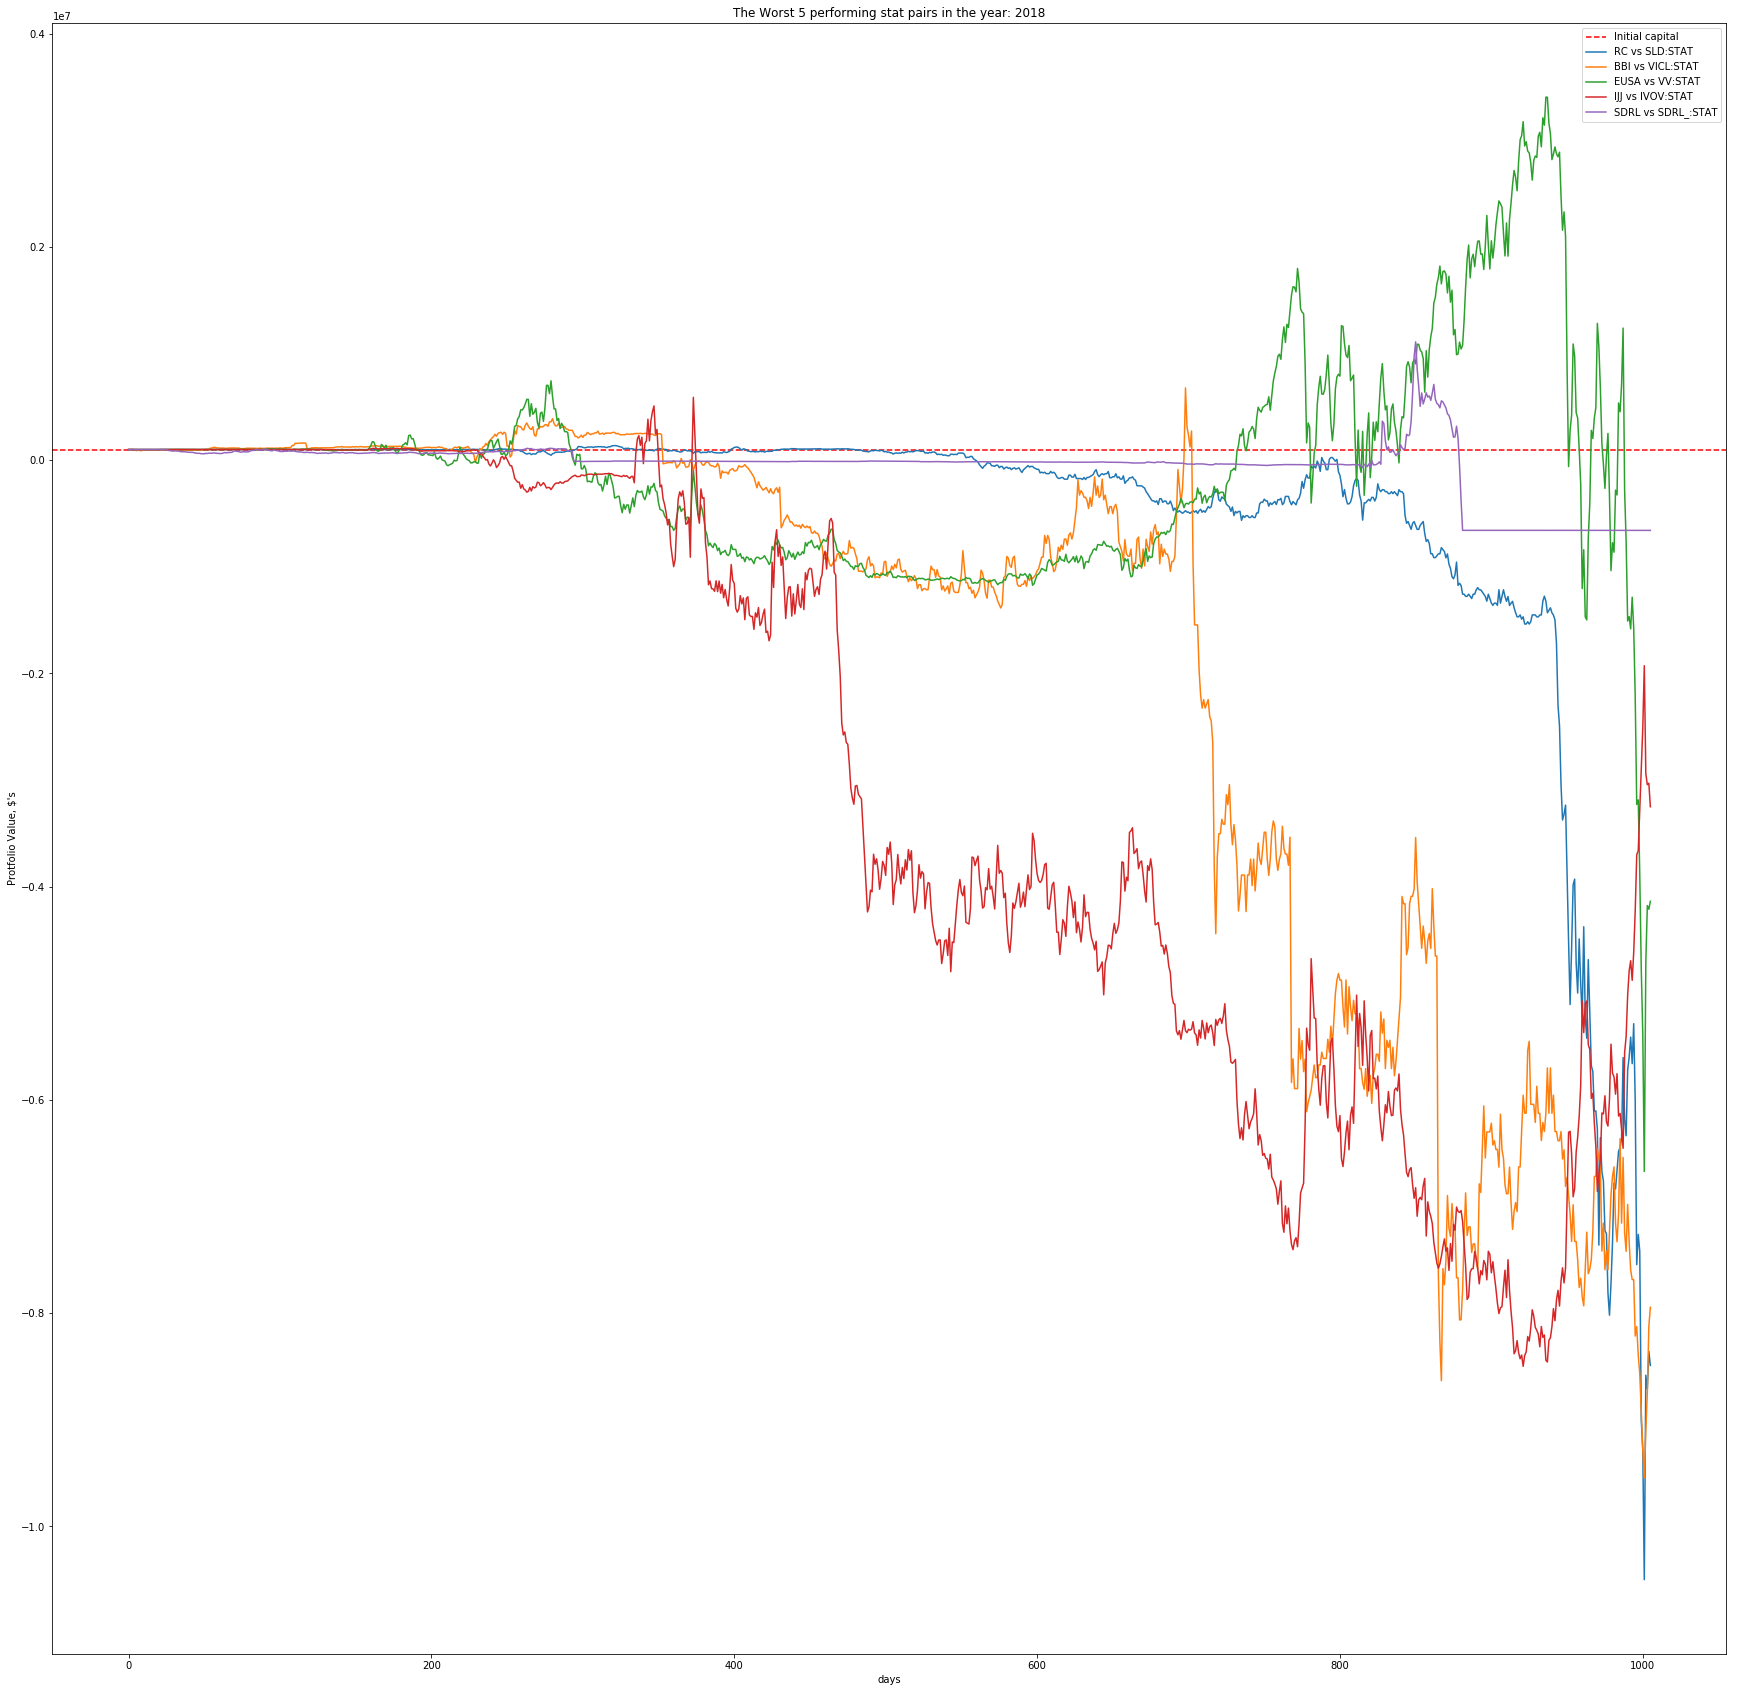

In [20]:
### GETTING STAT AVERAGE RESULTS ### 
stat_average_perf = OrderedDict()
stat_pct_mean = OrderedDict()
stat_pct_std = OrderedDict()
stat_alpha_mean = OrderedDict()
stat_beta_mean = OrderedDict()
stat_sharpe_mean = OrderedDict()
stat_maxdraw_mean = OrderedDict()

best_5_perf_stat = OrderedDict()
worst_5_perf_stat = OrderedDict()

best_5_alpha_stat = OrderedDict()
best_5_beta_stat = OrderedDict()
best_5_sharpe_stat = OrderedDict()
best_5_maxdraw_stat = OrderedDict()

worst_5_alpha_stat = OrderedDict()
worst_5_beta_stat = OrderedDict()
worst_5_sharpe_stat = OrderedDict()
worst_5_maxdraw_stat = OrderedDict()

data_len_stat = len(stat_data)

for year in years:
    stat_average_perf[year] = round(stat_data['perf_' + str(year)].mean(), 2)
    stat_pct_mean[year]     = round(stat_data['pct_' + str(year)].mean(), 2)
    stat_pct_std[year]      = round(stat_data['pct_'+str(year)].std(), 2)
    stat_alpha_mean[year]   = round(stat_data['alpha_' + str(year)].mean(), 2)
    stat_beta_mean[year]    = round(stat_data['beta_' + str(year)].mean(), 2)
    stat_sharpe_mean[year]  = round(stat_data['sharpe_' + str(year)].mean(), 2)
    stat_maxdraw_mean[year] = round(stat_data['maxdraw_'+str(year)].mean(), 2)
    
    d = pd.read_csv(file_data + '/pair_sim_' + str(year)+'.csv')
    best_idx = [stat_data['perf_'+str(year)].sort_values()[data_len_stat-5:data_len_stat].index[i] for i in range(5)]
    worst_idx = [stat_data['perf_'+str(year)].sort_values()[:5].index[i] for i in range(5)]
    
    best_5_perf_stat[year] = [(best_idx[i], d[best_idx[i]]) for i in range(len(best_idx))]
    worst_5_perf_stat[year] = [(worst_idx[i], d[worst_idx[i]]) for i in range(len(worst_idx))]
    
    best_5_alpha_stat[year] = [(best_idx[i], stat_data['alpha_' + str(year)].loc[best_idx[i]]) for i in range(len(best_idx))]
    worst_5_alpha_stat[year] = [(worst_idx[i], stat_data['alpha_' + str(year)].loc[worst_idx[i]]) for i in range(len(worst_idx))]
    
    best_5_beta_stat[year] = [(best_idx[i], stat_data['beta_' + str(year)].loc[best_idx[i]]) for i in range(len(best_idx))]
    worst_5_beta_stat[year] = [(worst_idx[i], stat_data['beta_' + str(year)].loc[worst_idx[i]]) for i in range(len(worst_idx))]

    best_5_sharpe_stat[year] = [(best_idx[i], stat_data['sharpe_' + str(year)].loc[best_idx[i]]) for i in range(len(best_idx))]
    worst_5_sharpe_stat[year] = [(worst_idx[i], stat_data['sharpe_' + str(year)].loc[worst_idx[i]]) for i in range(len(worst_idx))]
     
    best_5_maxdraw_stat[year] = [(best_idx[i], stat_data['maxdraw_'+str(year)].loc[best_idx[i]]) for i in range(len(best_idx))]
    worst_5_maxdraw_stat[year] = [(worst_idx[i], stat_data['maxdraw_'+str(year)].loc[worst_idx[i]]) for i in range(len(worst_idx))]

colnames = ['average portfolio value', 'average percentage change', 'average standard deviation',
            'average alpha', 'average beta', 'average sharpe ratio', 'average max drawdown']

list_of_dicts = [stat_average_perf,stat_pct_mean, stat_pct_std,
                 stat_alpha_mean, stat_beta_mean,stat_sharpe_mean, stat_maxdraw_mean ]

main_df = pd.DataFrame()
main_df['year'] = pd.Series(years)

for i in range(len(list_of_dicts)):
    df = pd.DataFrame(data=list(list_of_dicts[i].items()) , columns=['year', colnames[i]] )
    main_df = pd.concat([main_df, df[colnames[i]]], axis=1)
main_df.to_latex(buf=file_data+'stat-perf-part3.txt', index=False)
    

for year in years:
    fig, ax = plt.subplots(figsize = (30, 30))
    ax.set_ylabel("Protfolio Value, $'s")
    ax.set_xlabel('days')
    plt.axhline(100000, color='red', ls='--', label='Initial capital')
    plt.title('The Best 5 performing stat pairs in the year: {}'.format(year))
    
    for i in range(len(best_5_perf_stat[year])):
        ax.plot(best_5_perf_stat[year][i][1])
    plt.legend(loc='best')
    plt.savefig(fname=file_data + '/PLOTS/STAT/best_5_stat_year_' + str(year) + '.png')
    plt.show()
    
    fig1, ax1 = plt.subplots(figsize = (30, 30))
    ax1.set_ylabel("Protfolio Value, $'s")
    ax1.set_xlabel('days')
    plt.axhline(100000, color='red', ls='--', label='Initial capital')    
    for i in range(len(worst_5_perf_stat[year])):
        ax1.plot(worst_5_perf_stat[year][i][1])
        plt.title('The Worst 5 performing stat pairs in the year: {}'.format(year))
    plt.legend(loc='best')
    plt.savefig(fname=file_data + 'PLOTS/STAT/worst_5_stat_year_' + str(year) + '.png')
    plt.show() 

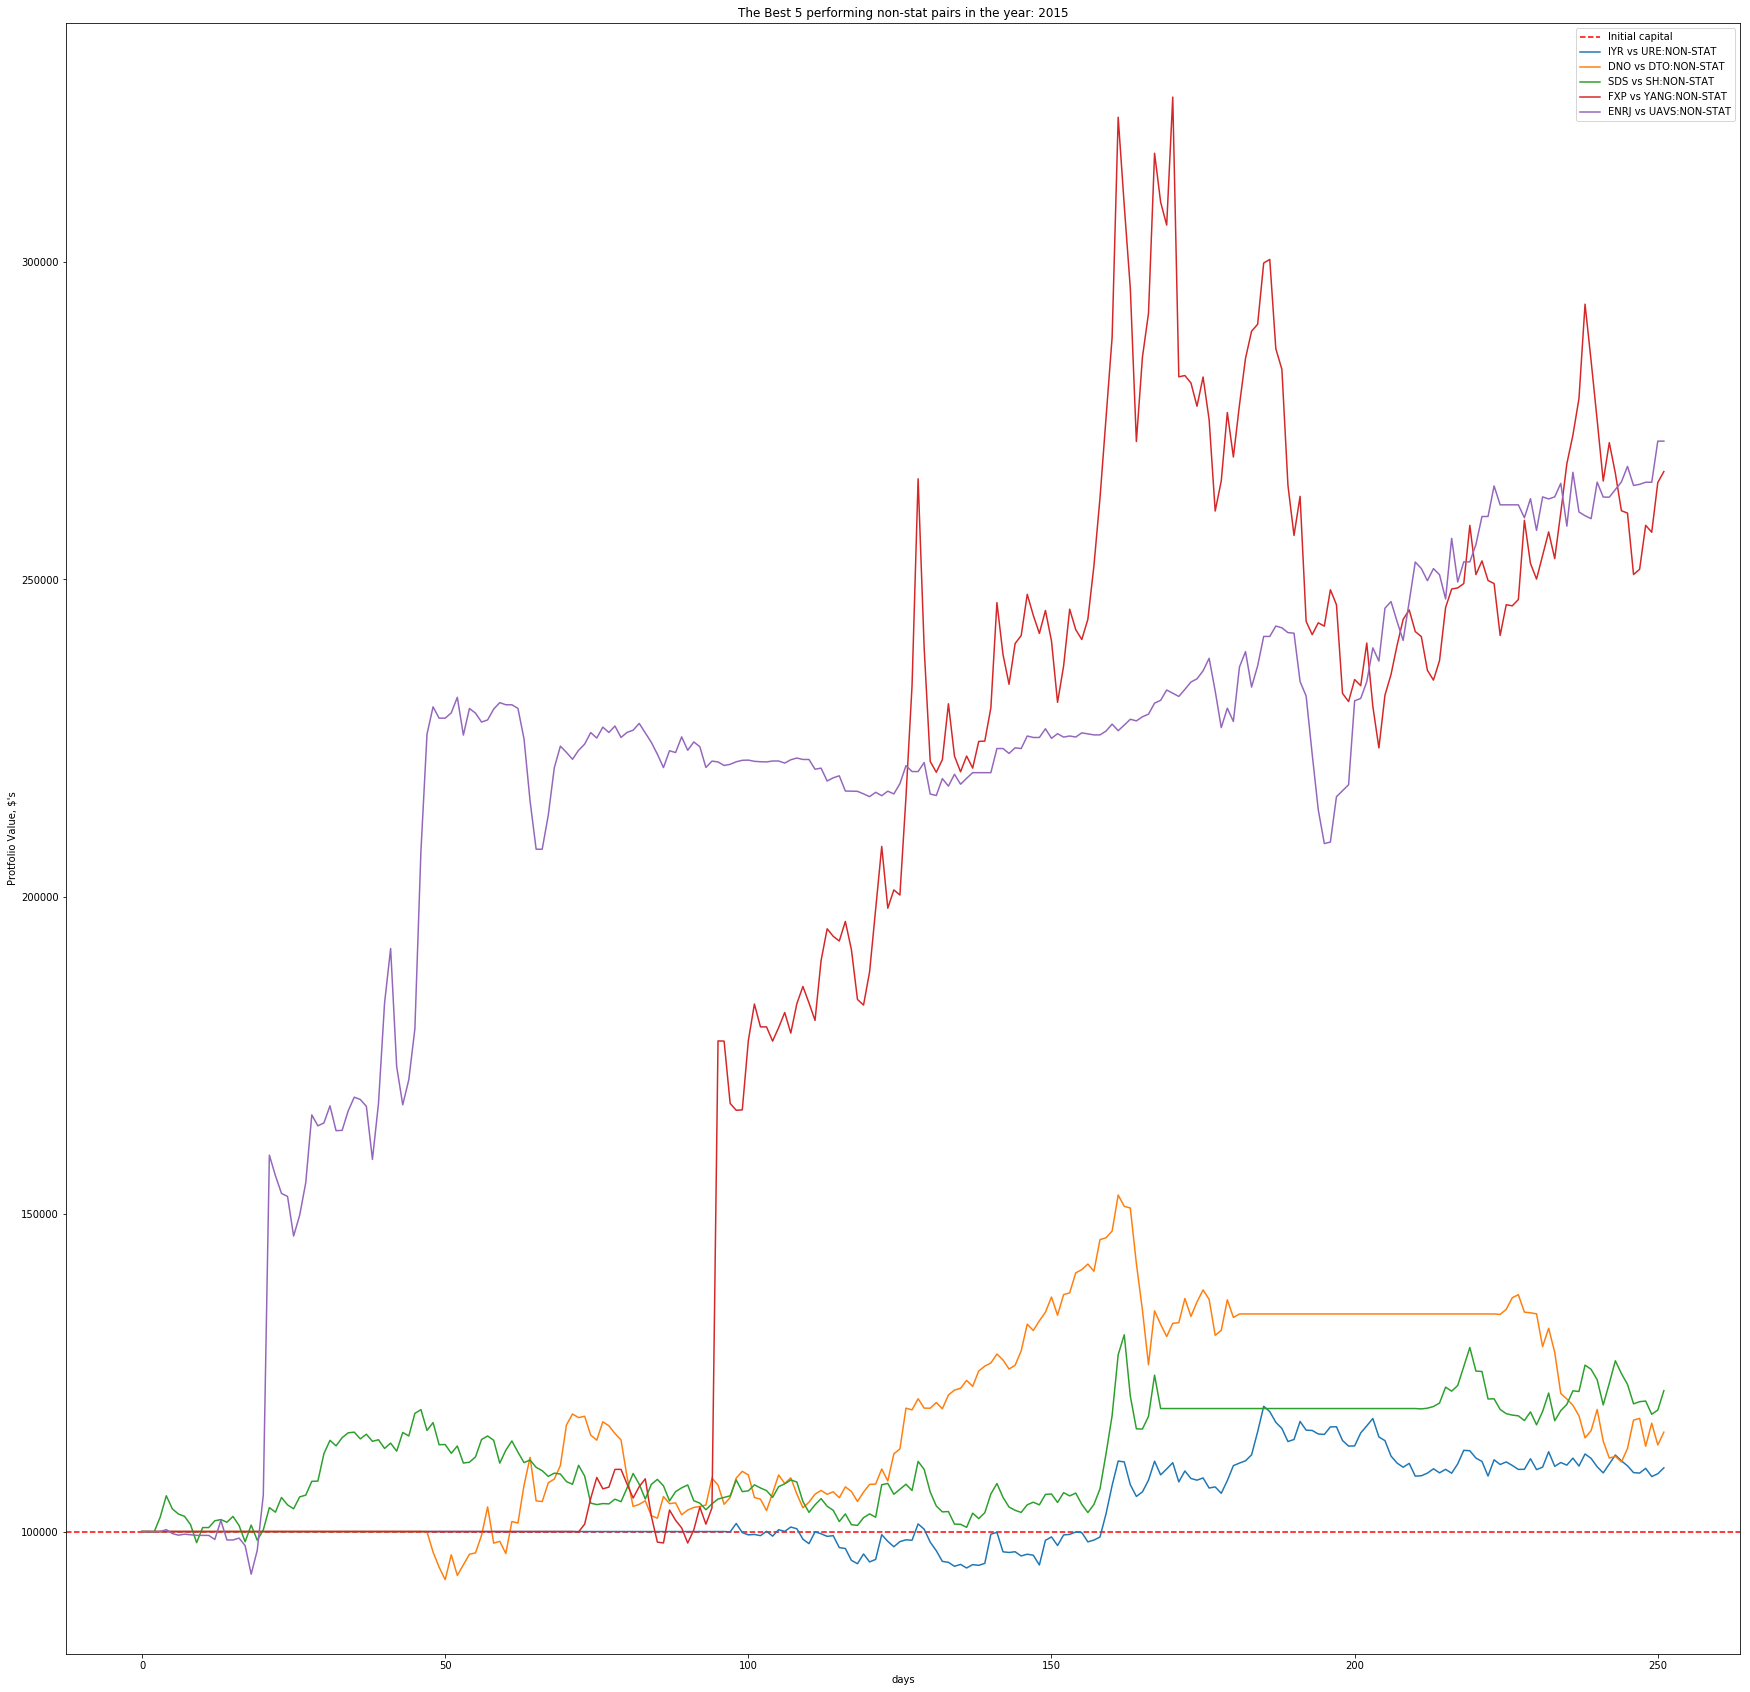

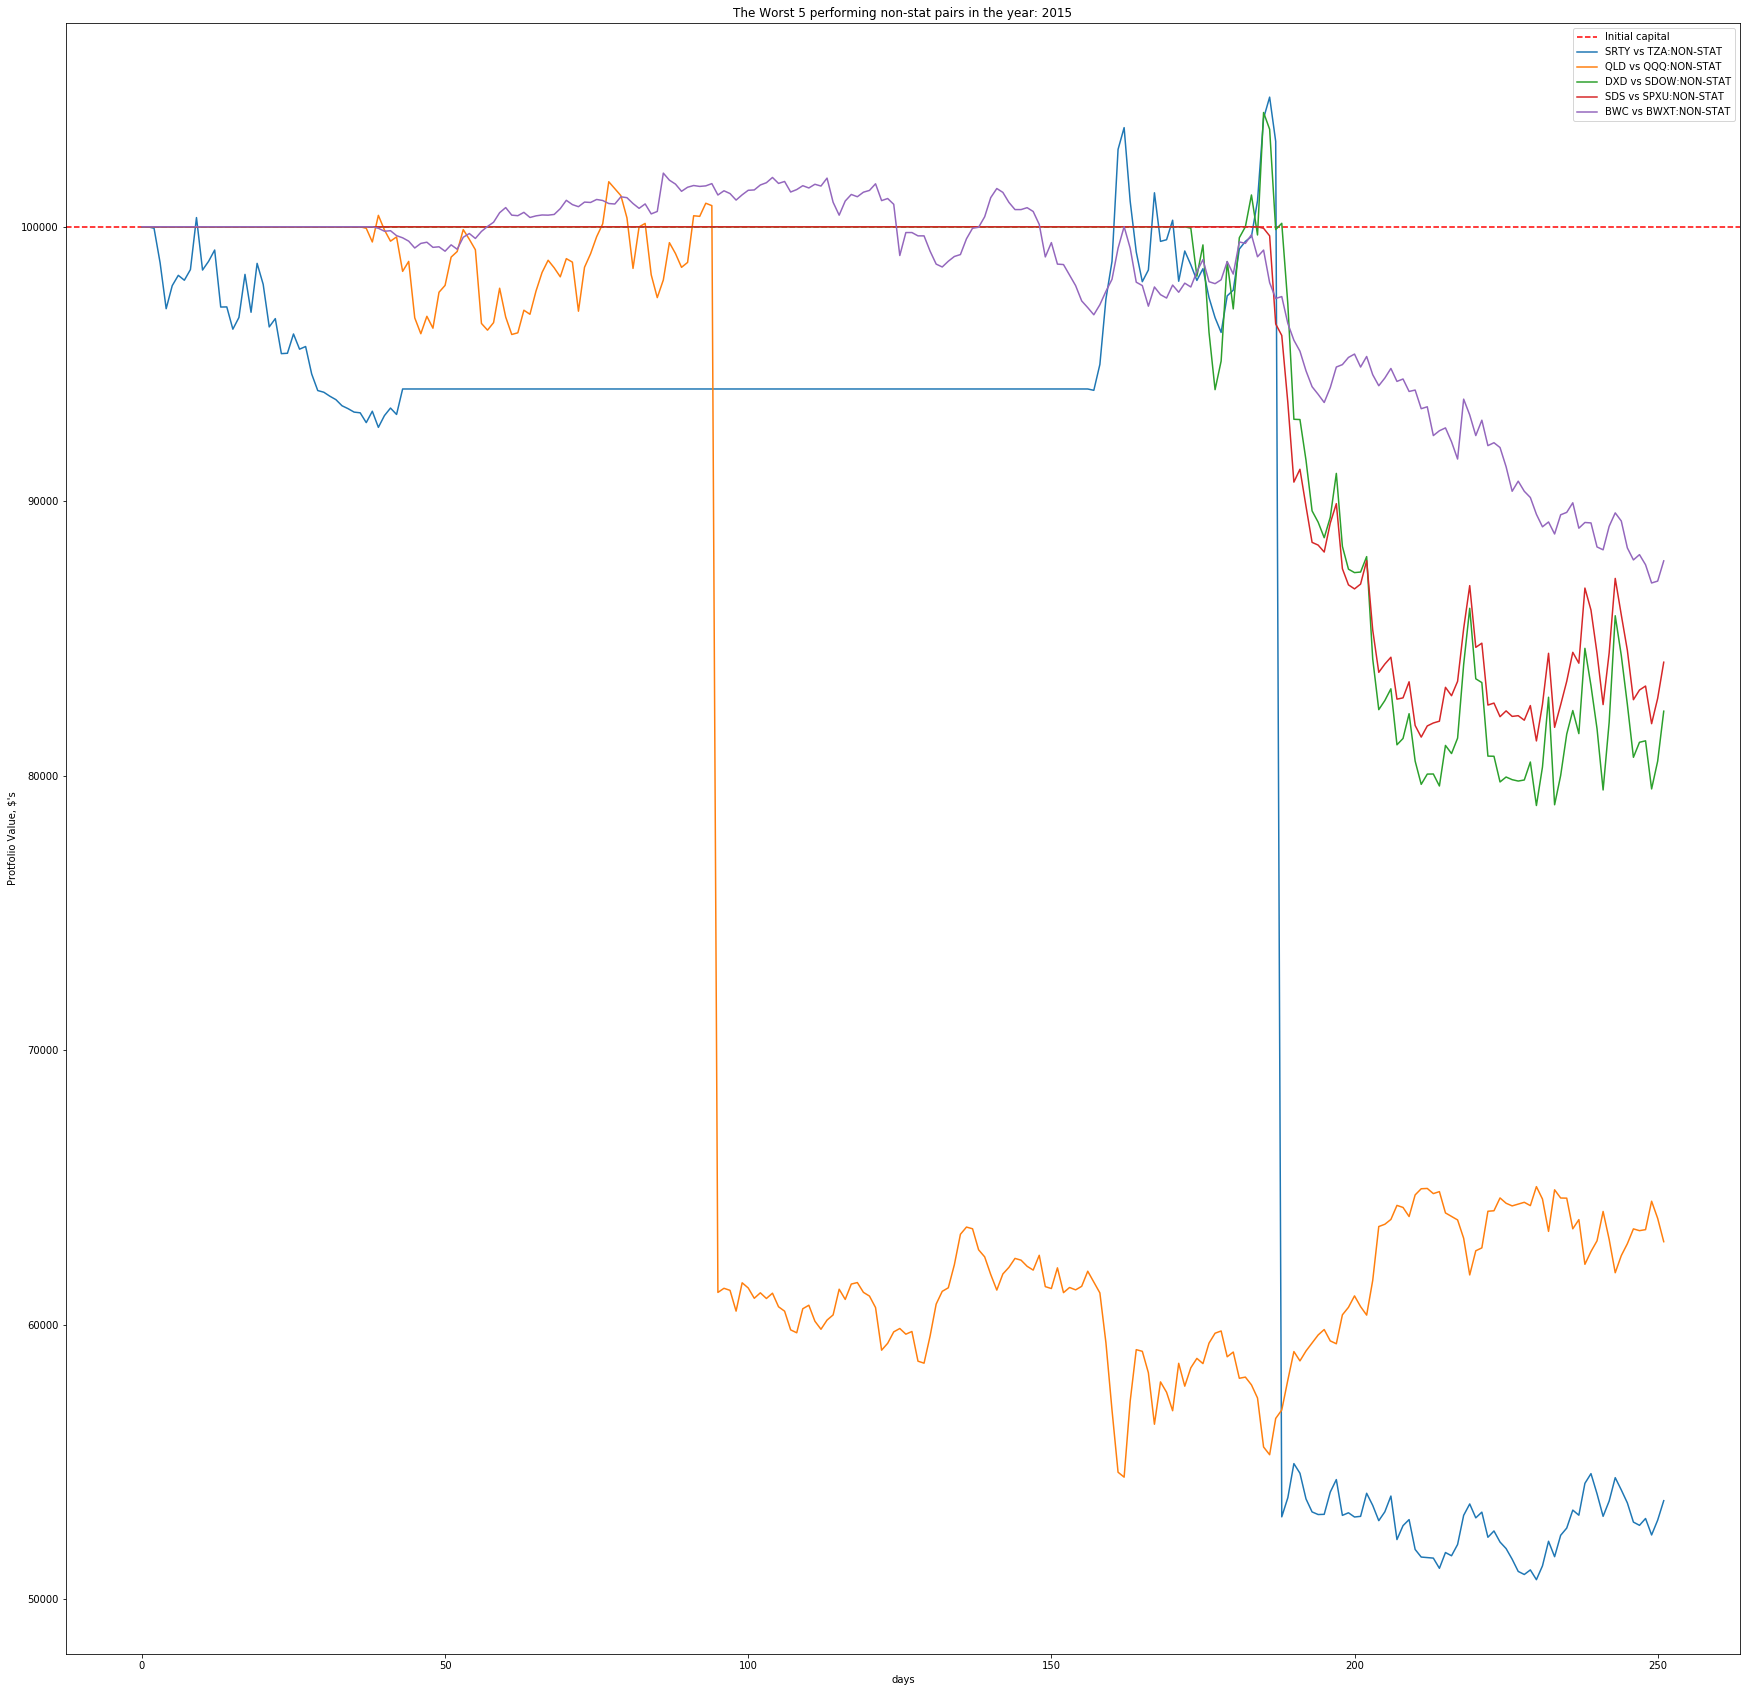

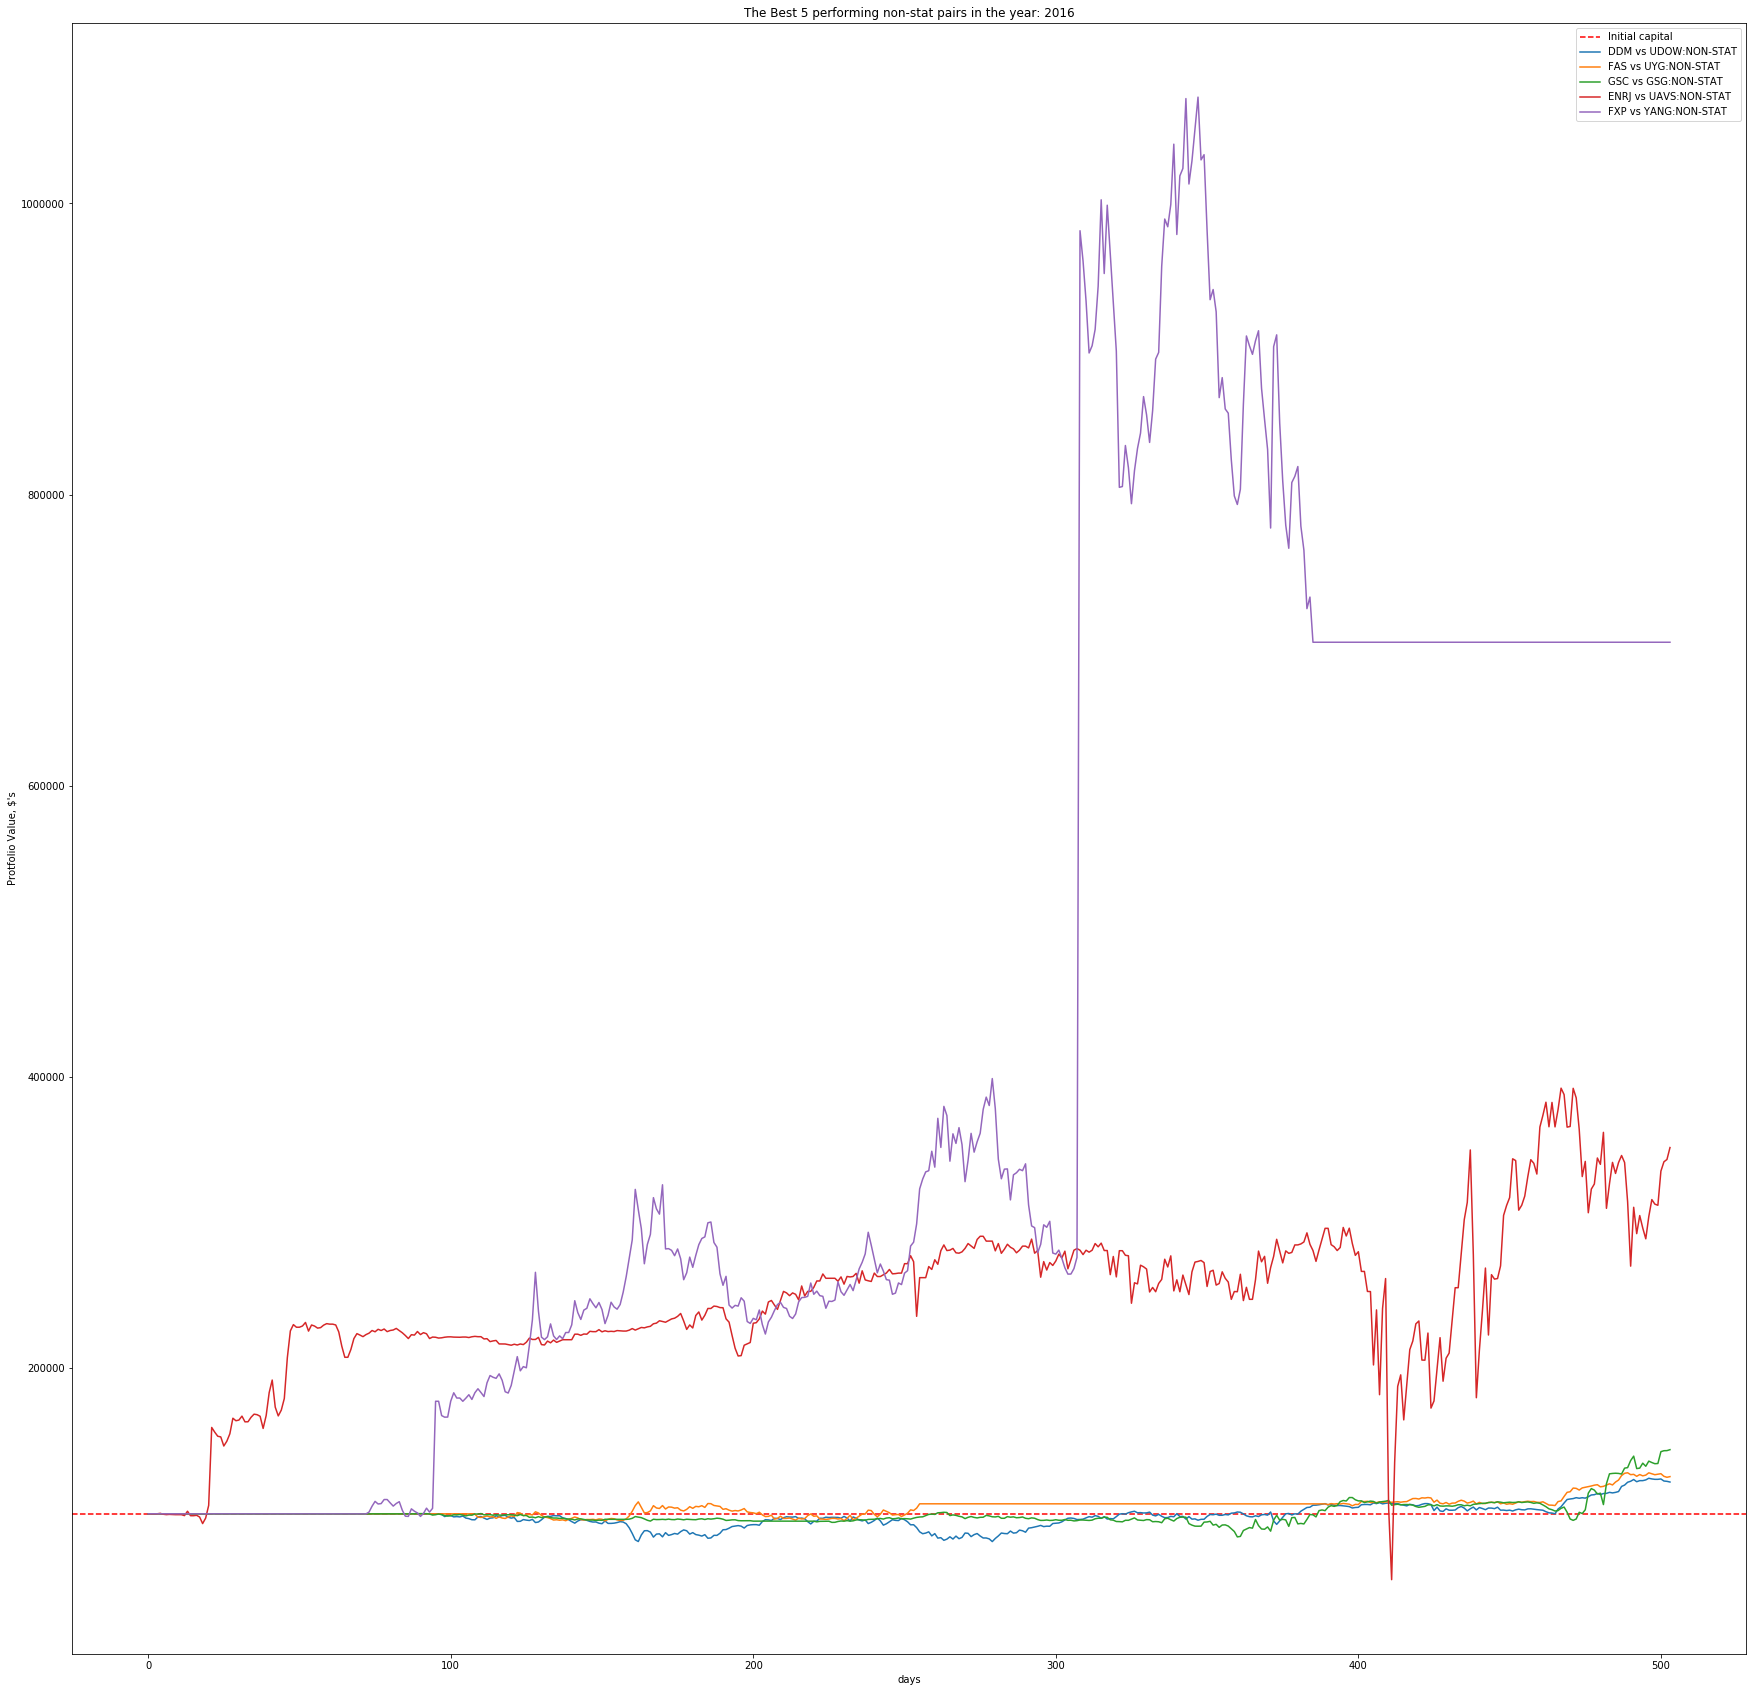

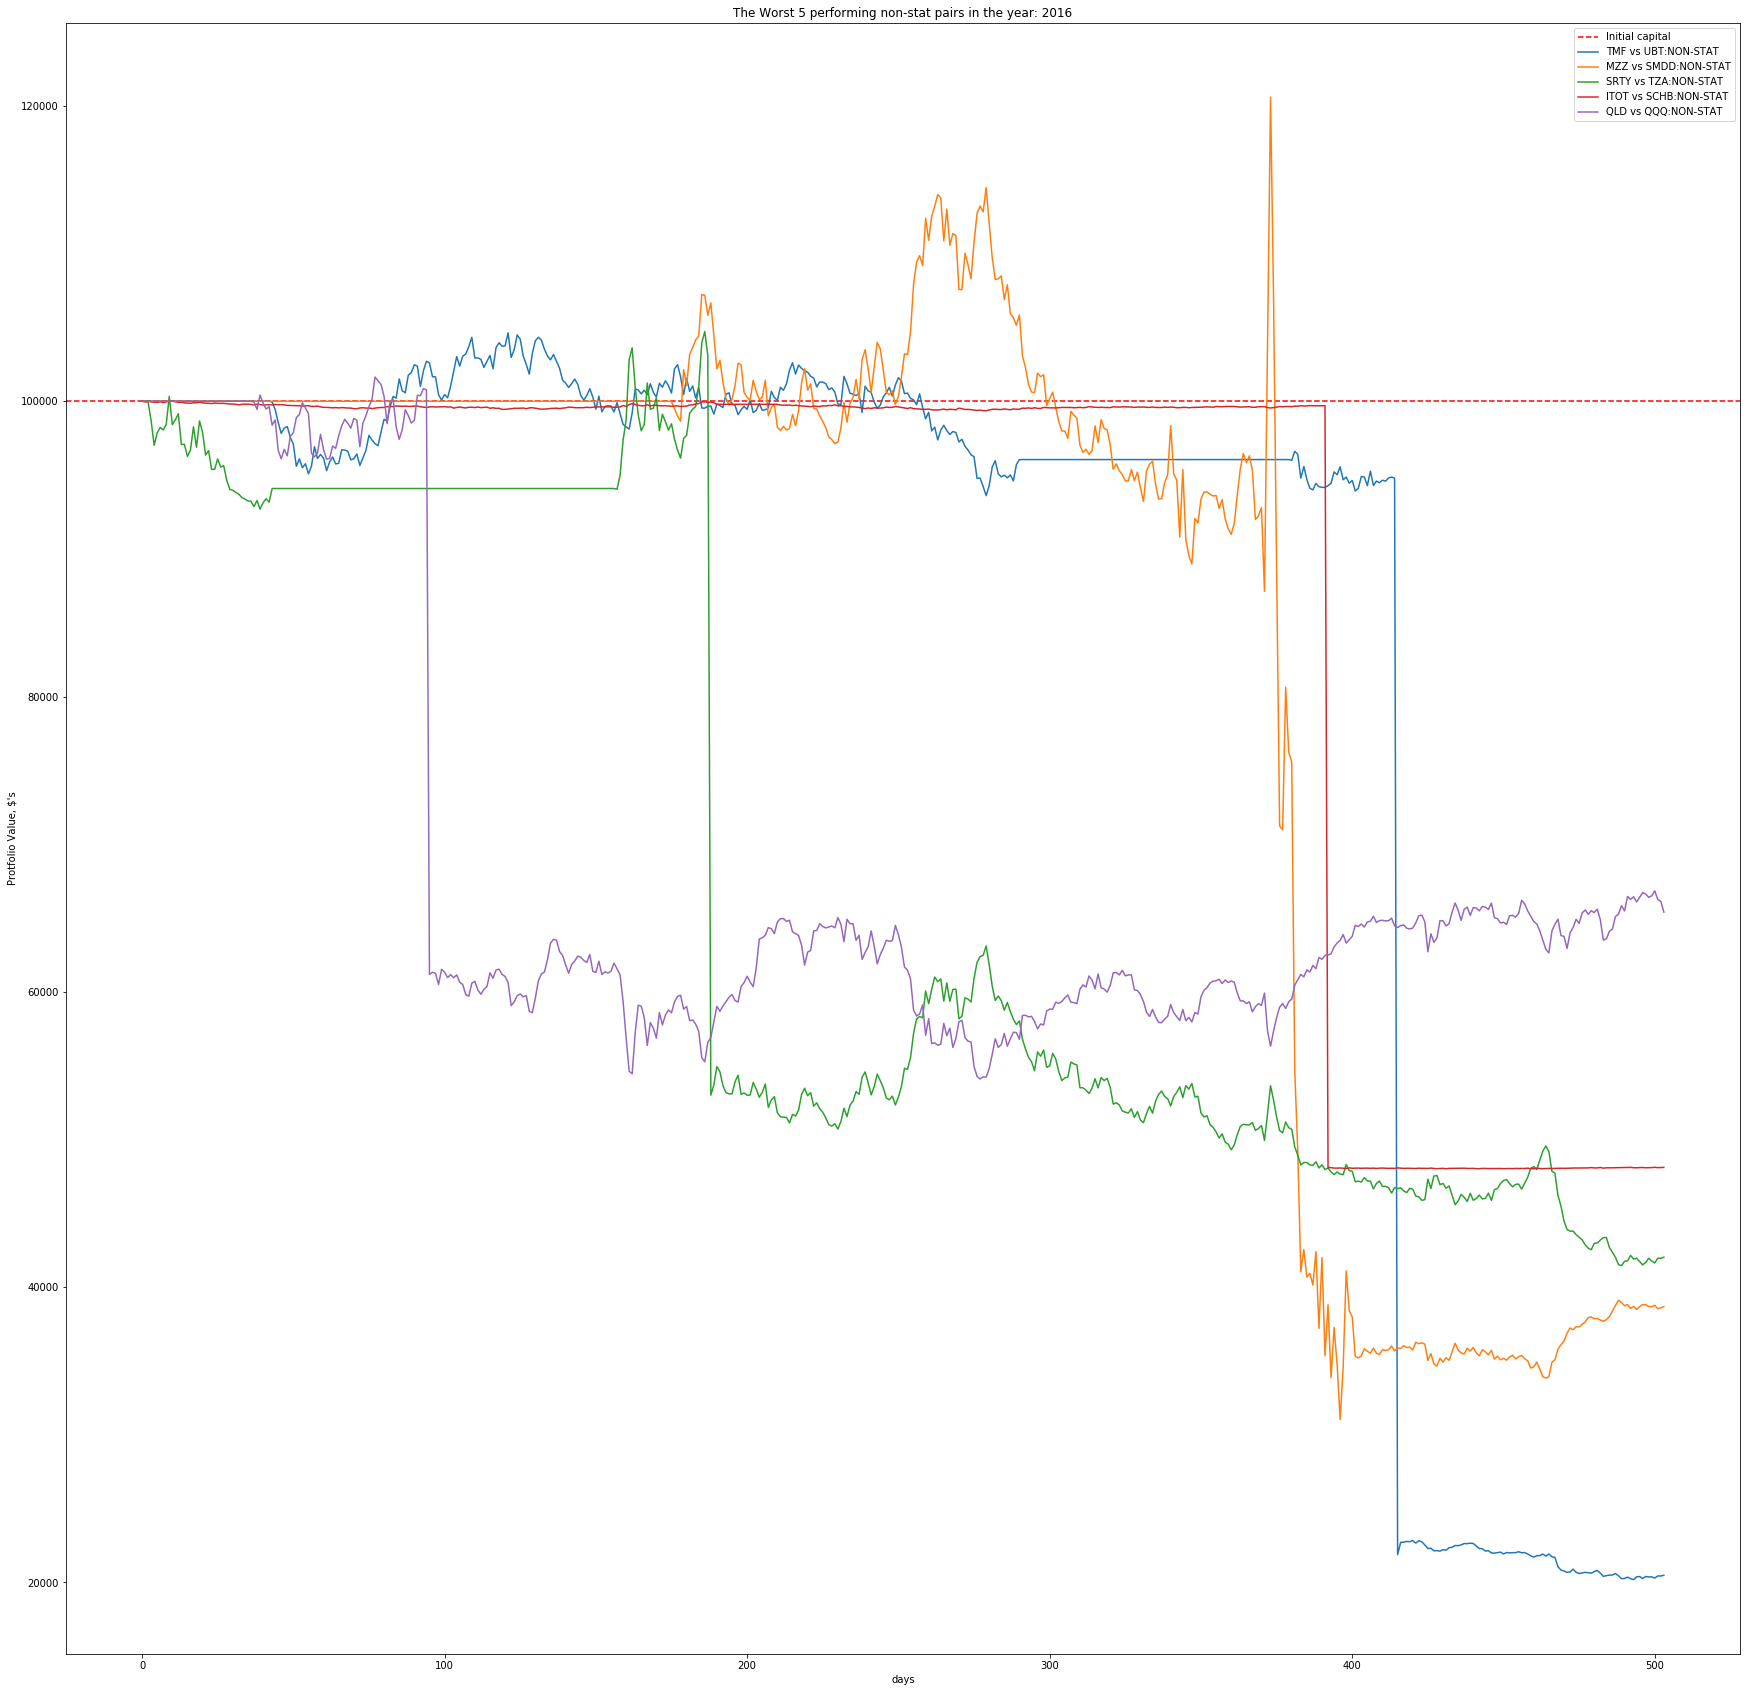

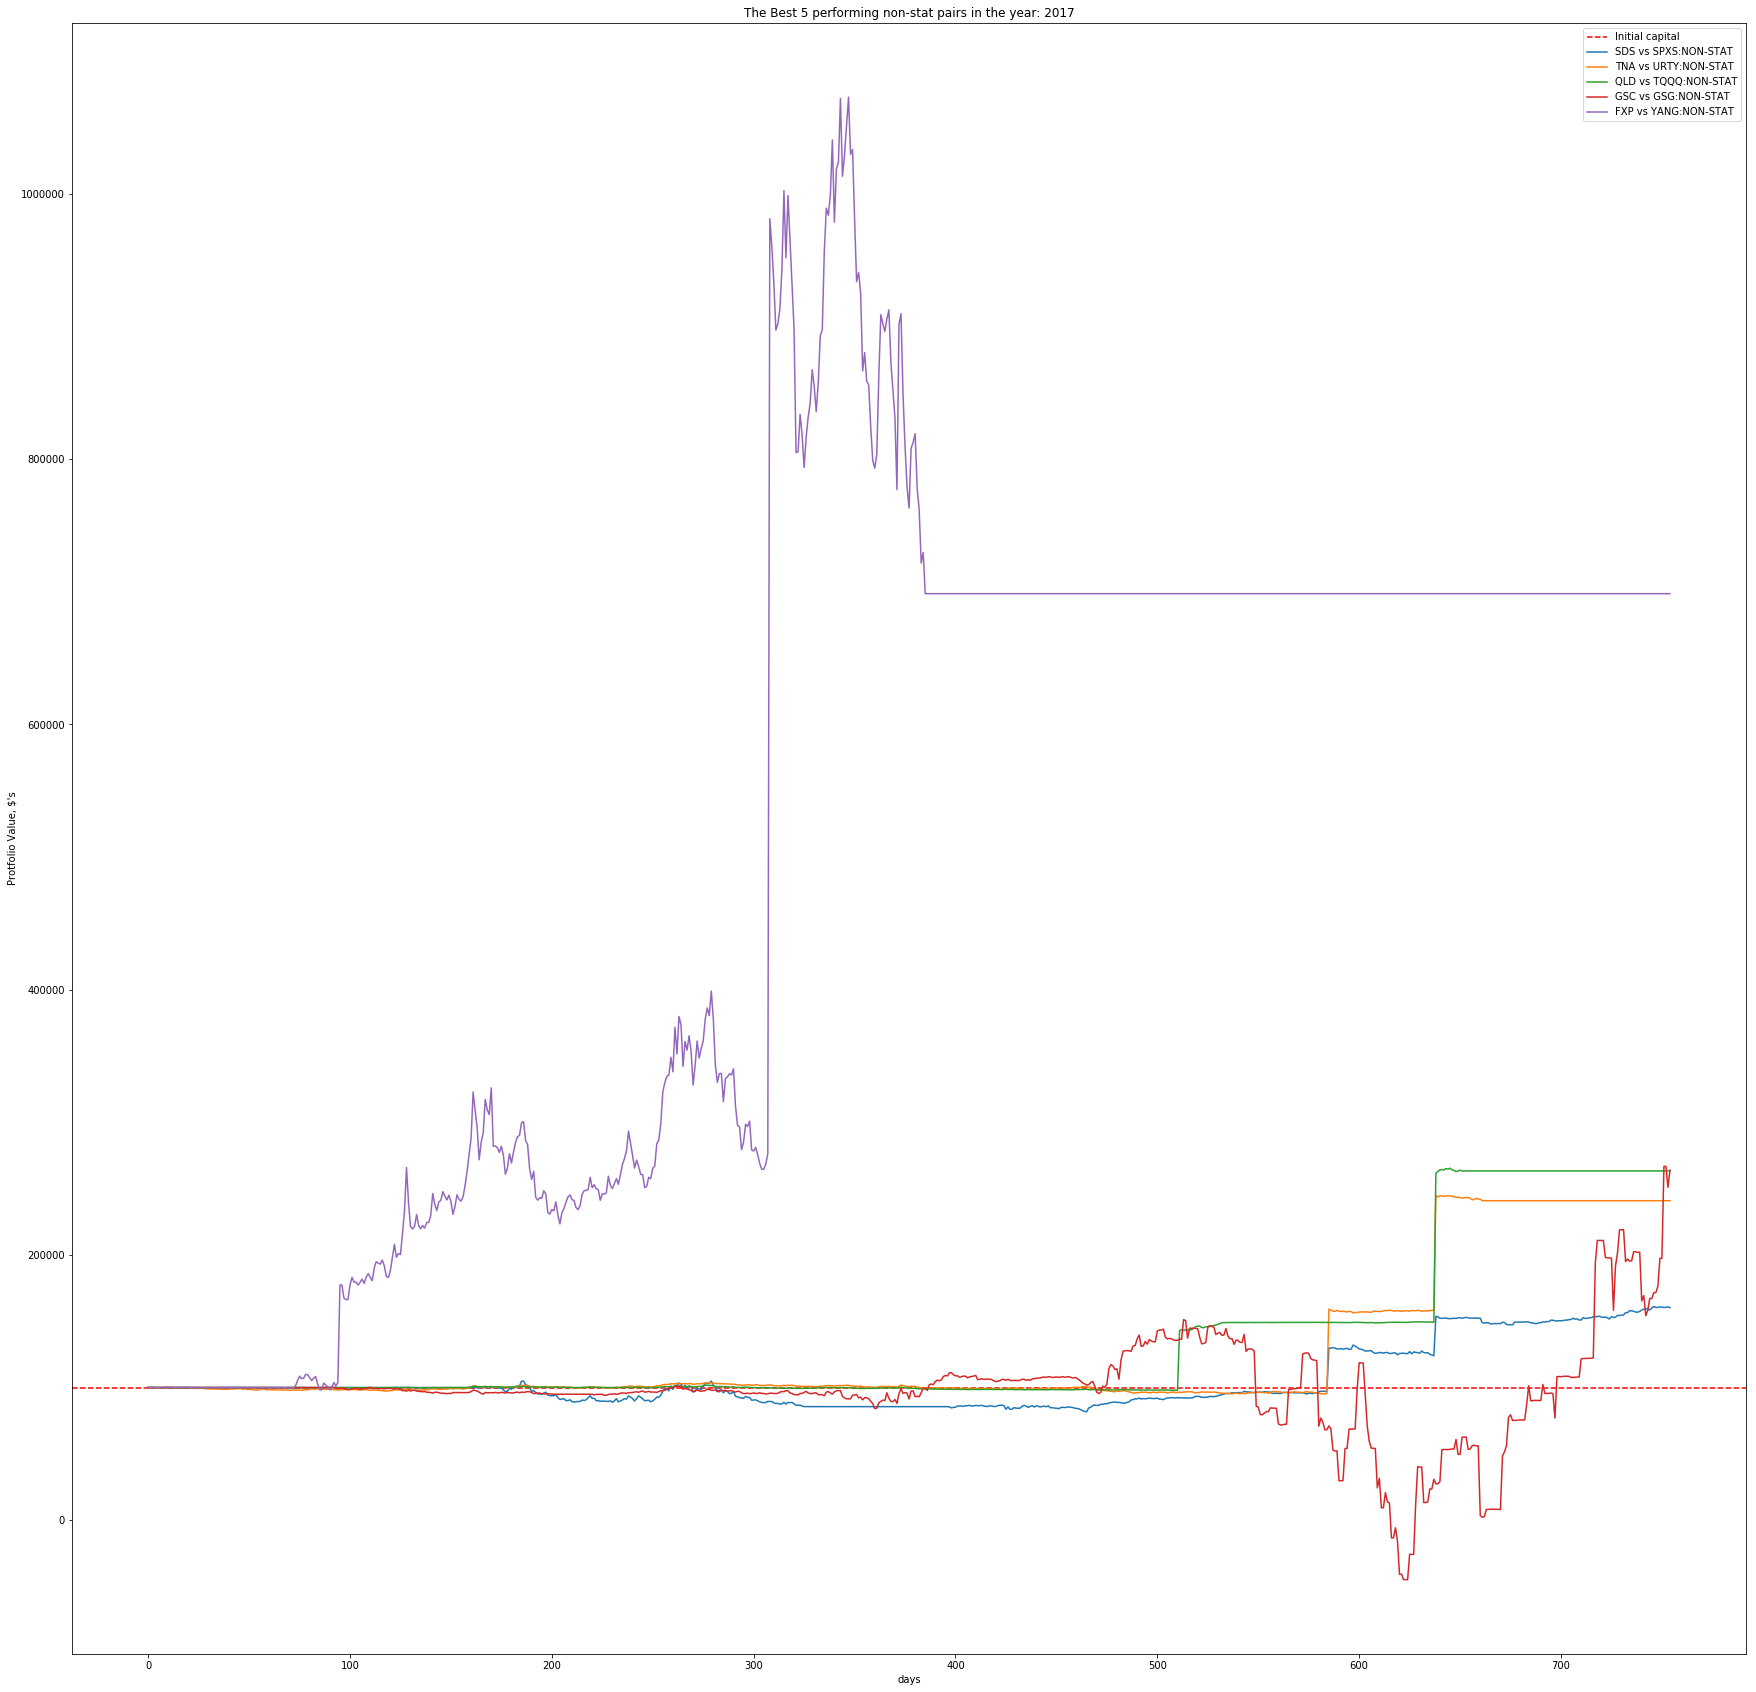

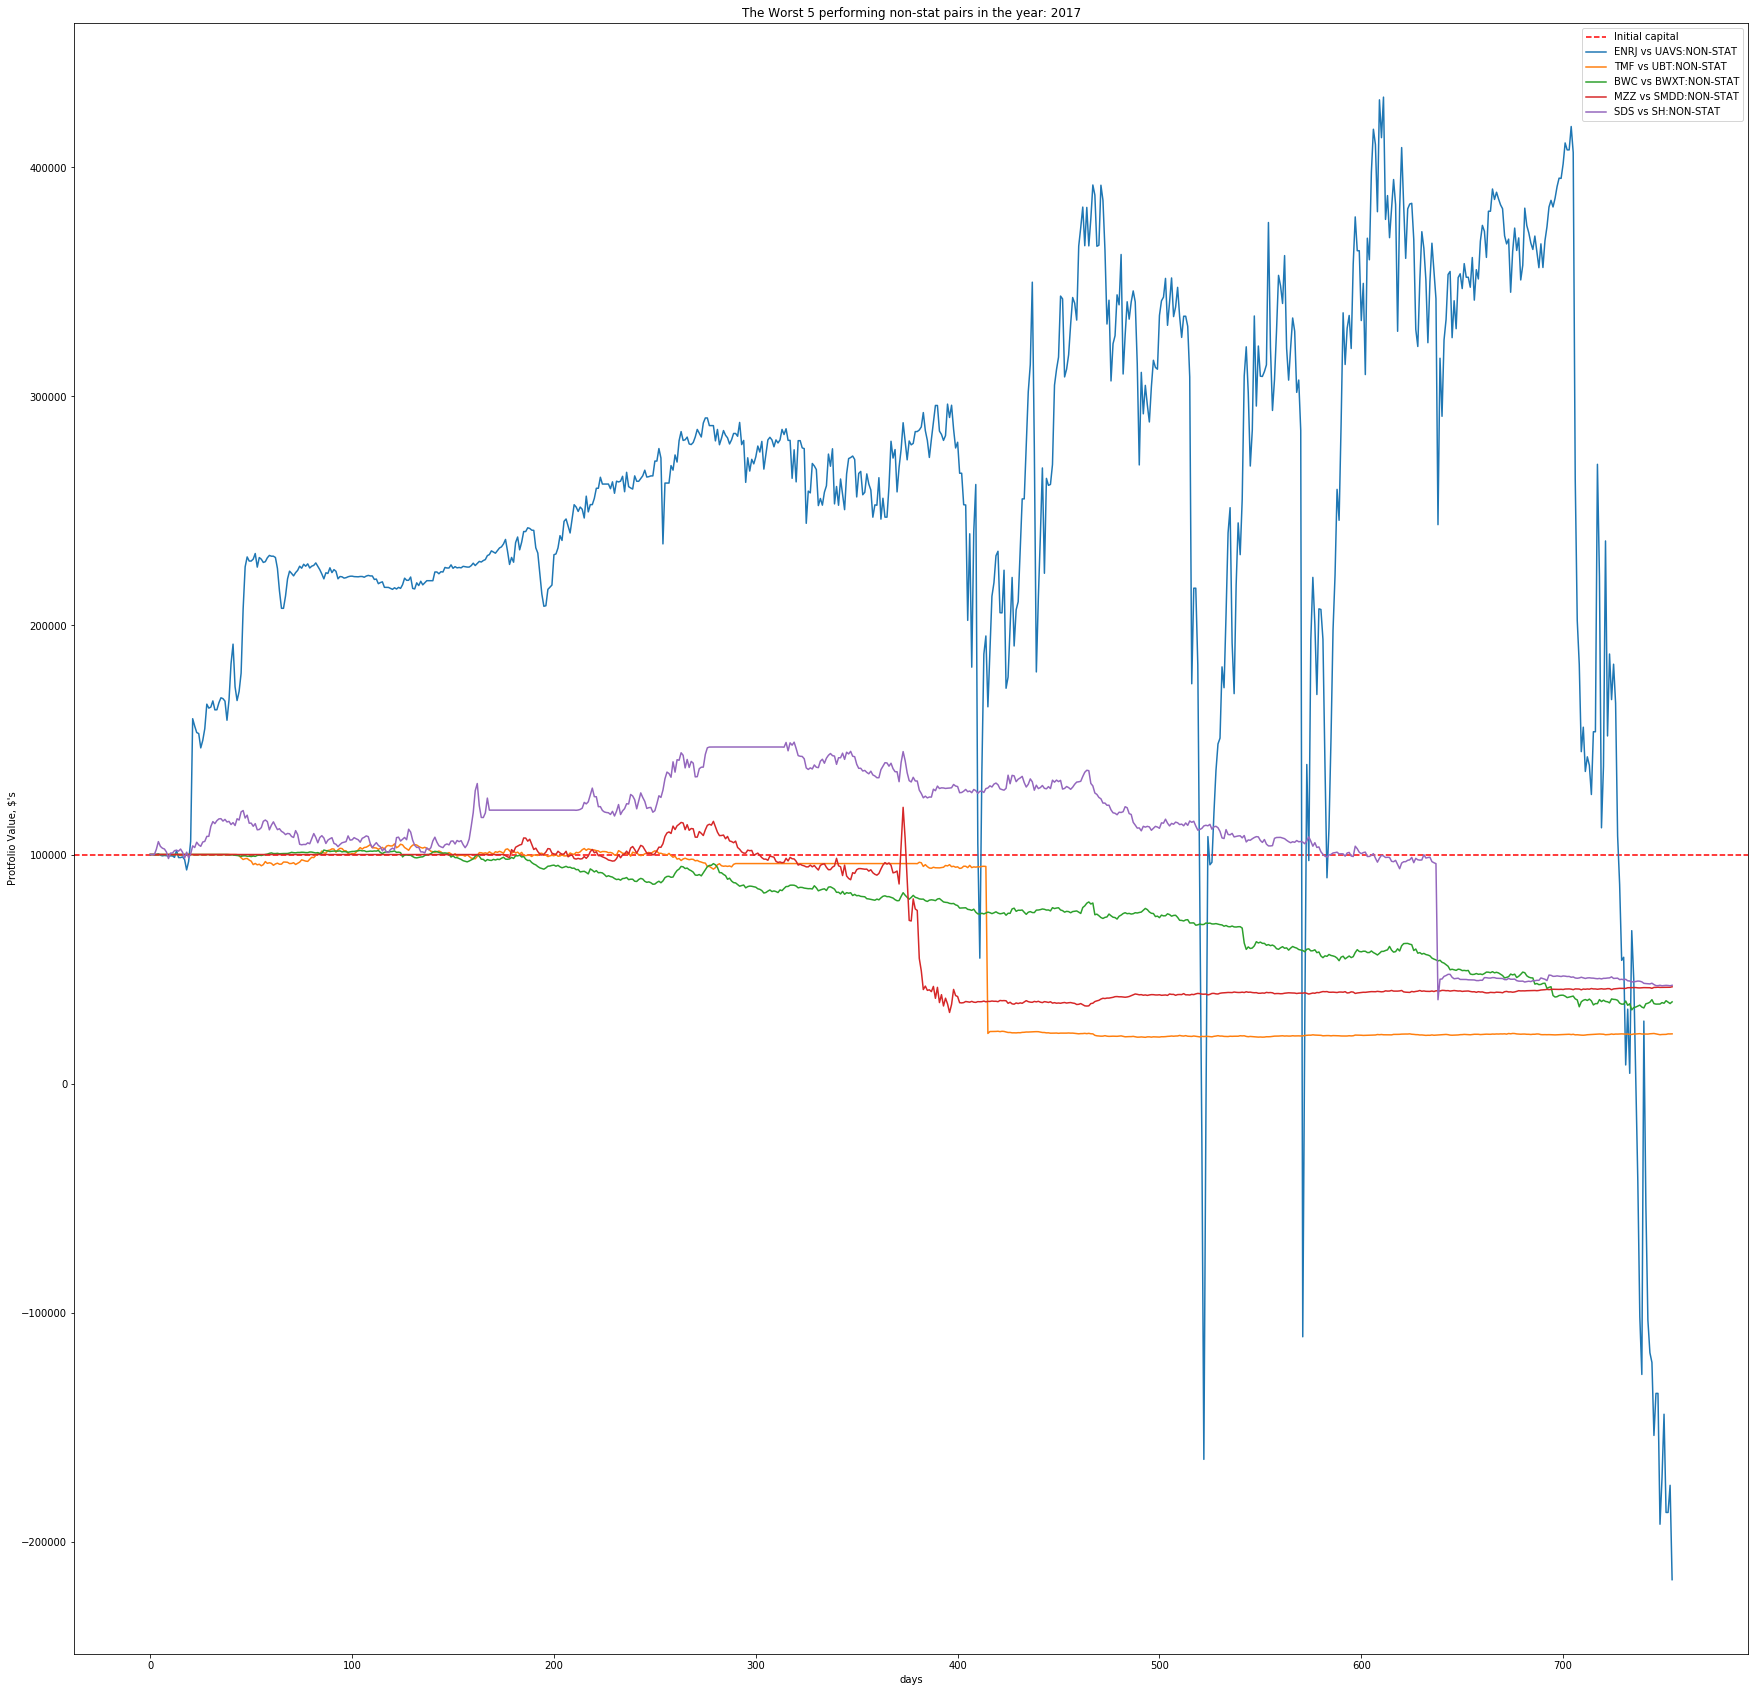

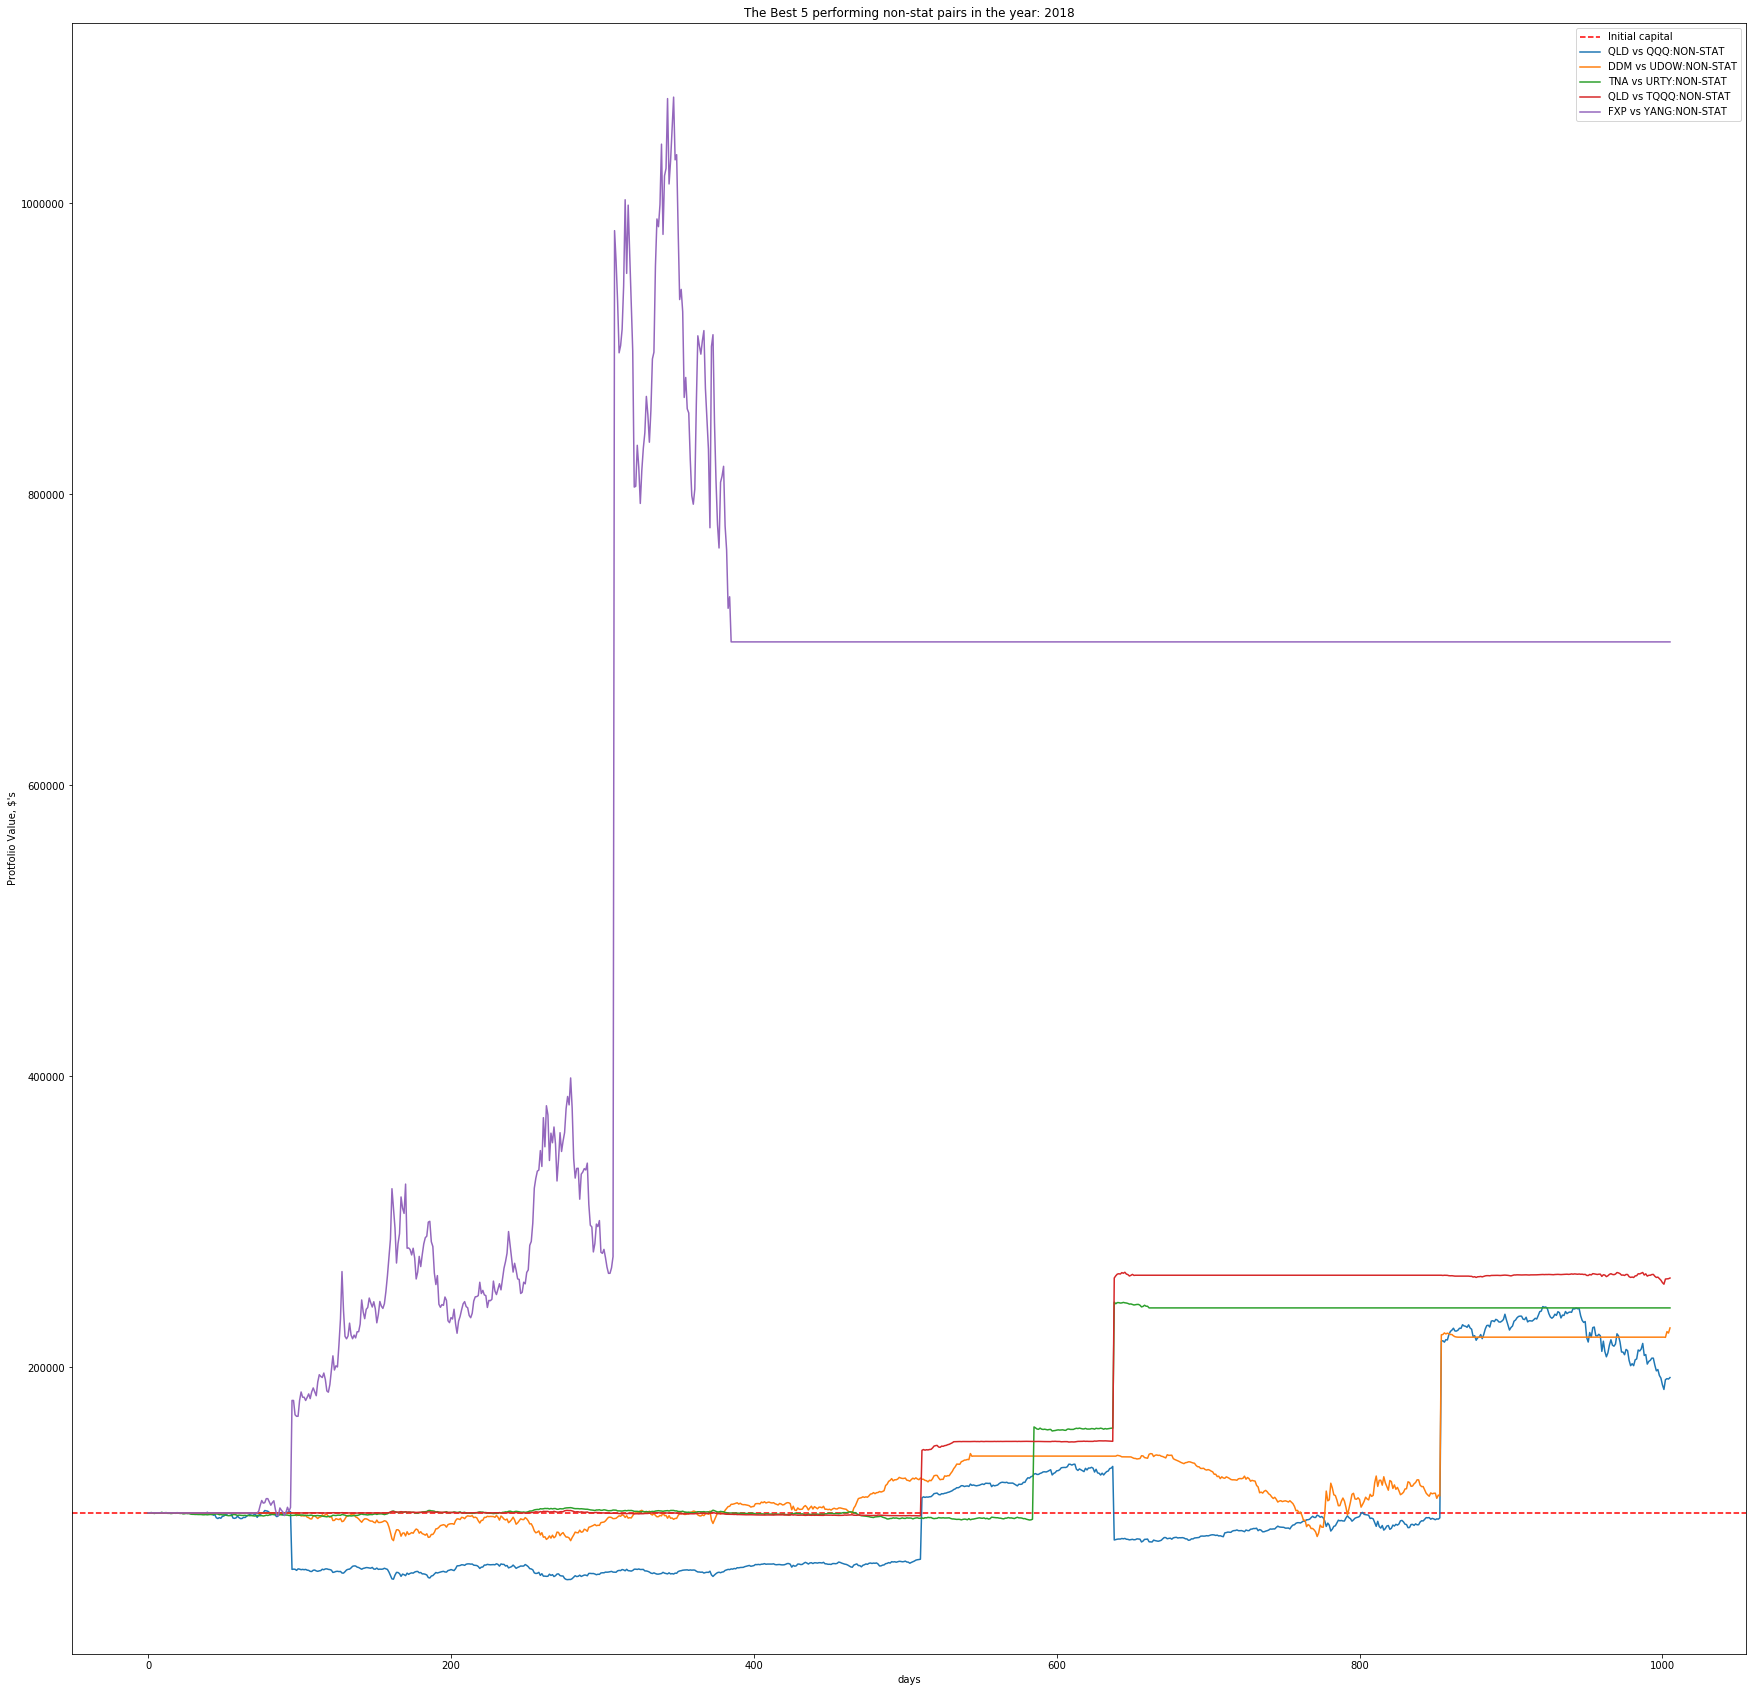

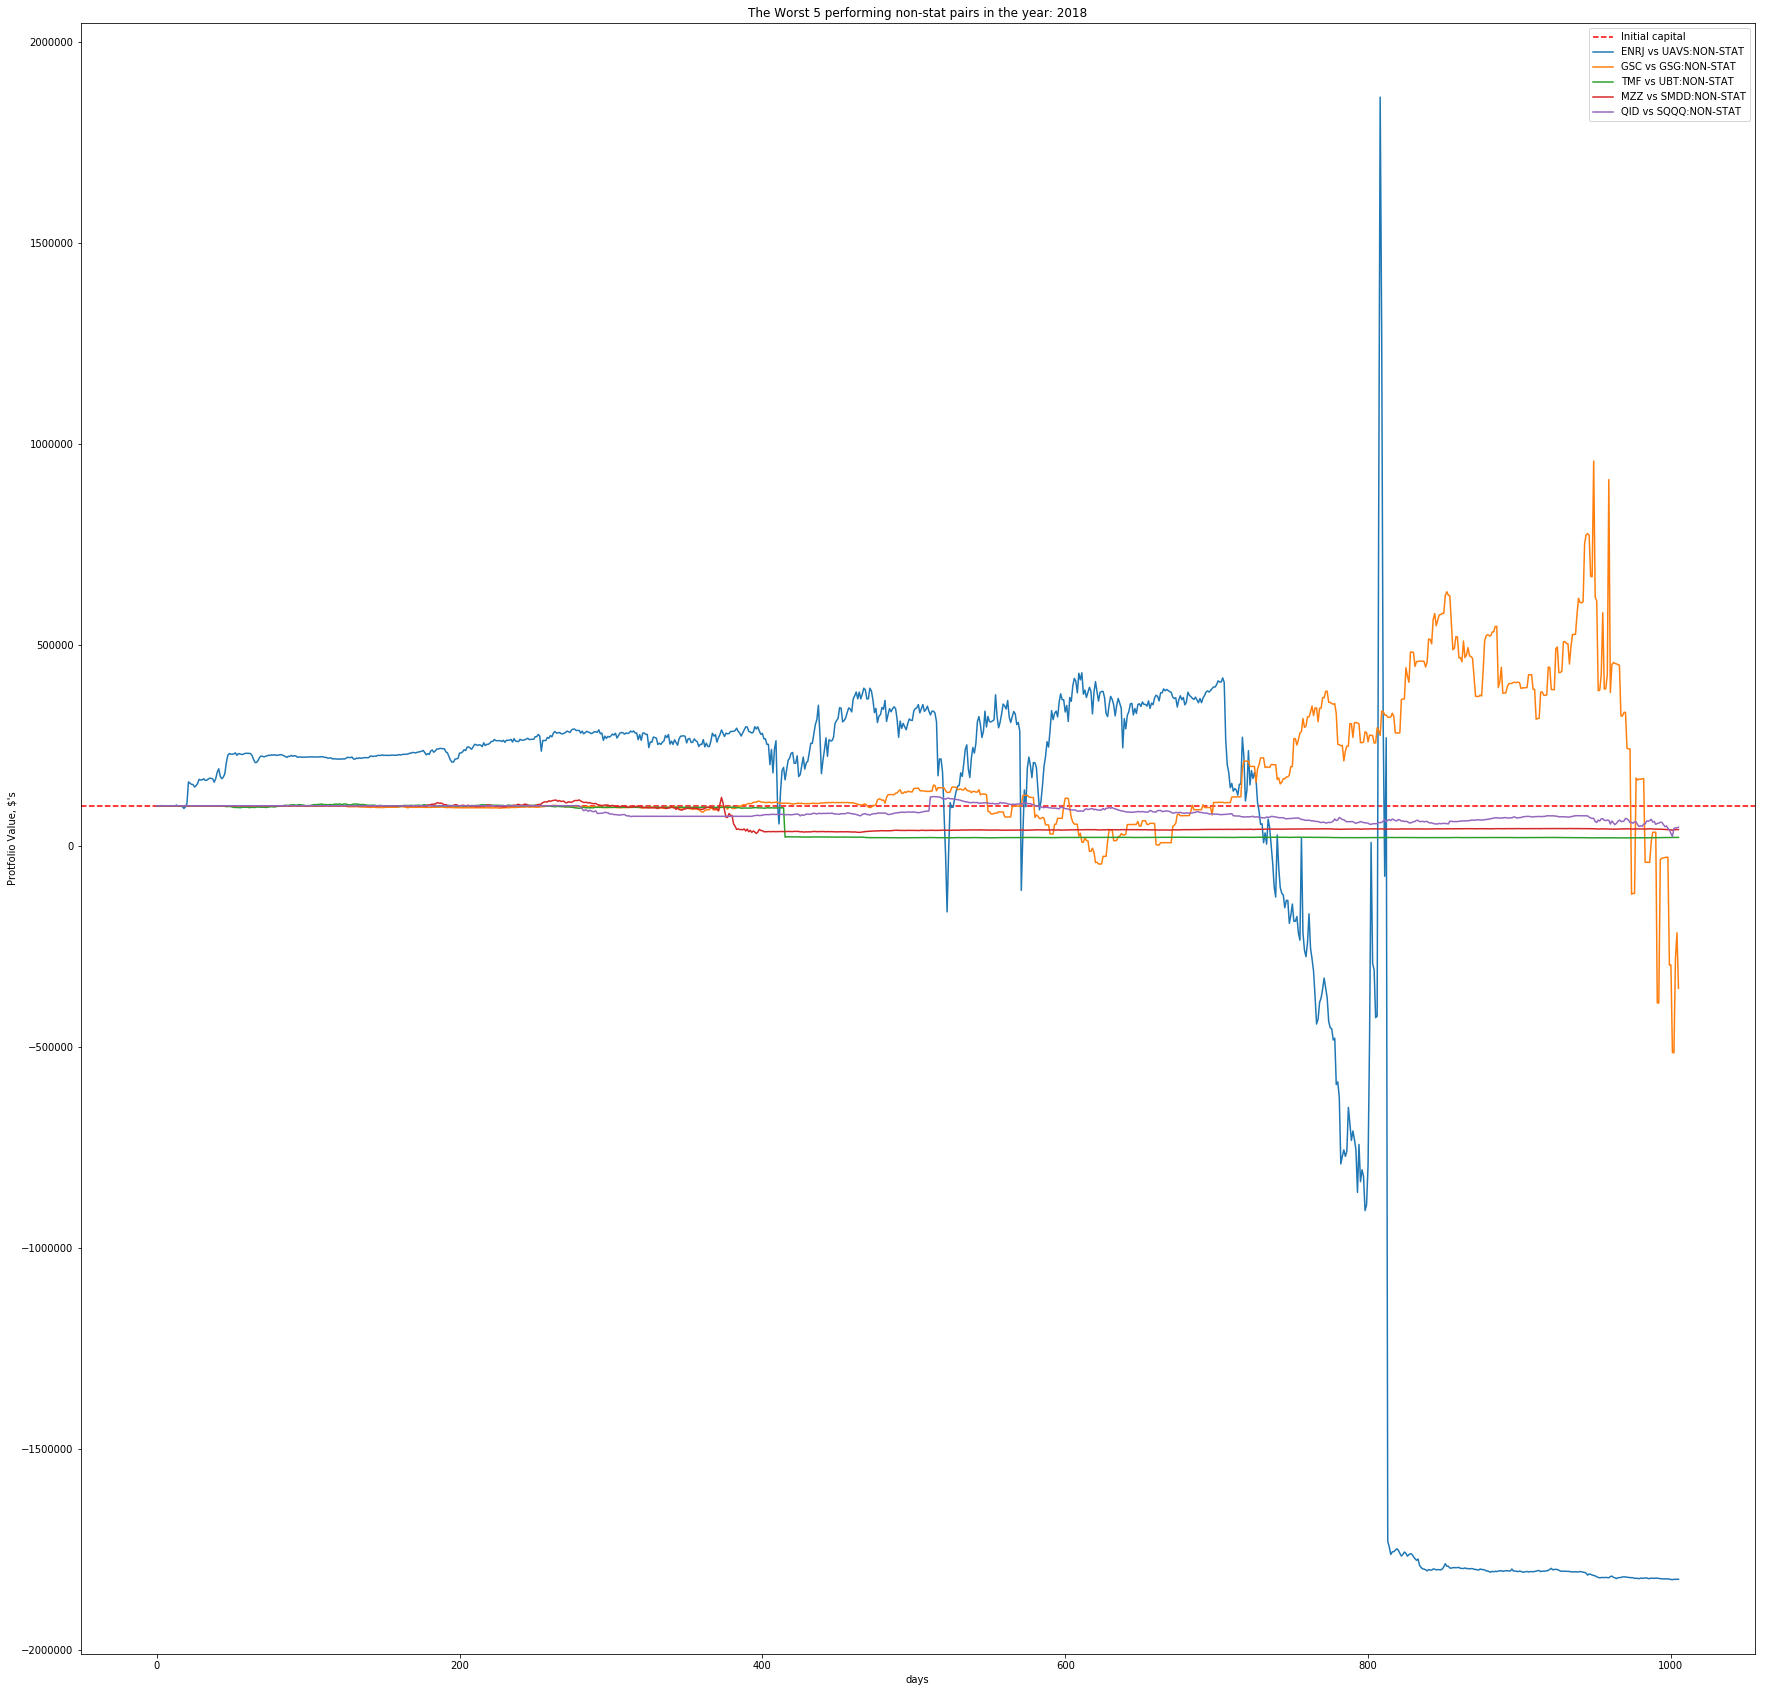

In [21]:
### GETTING NON-STAT AVERAGE RESULTS ### 
nstat_average_perf = OrderedDict()
nstat_pct_mean = OrderedDict()
nstat_pct_std = OrderedDict()
nstat_alpha_mean = OrderedDict()
nstat_beta_mean = OrderedDict()
nstat_sharpe_mean = OrderedDict()
nstat_maxdraw_mean = OrderedDict()

best_5_perf_nstat = OrderedDict()
worst_5_perf_nstat = OrderedDict()

best_5_alpha_nstat = OrderedDict()
best_5_beta_nstat = OrderedDict()
best_5_sharpe_nstat = OrderedDict()
best_5_maxdraw_nstat = OrderedDict()

worst_5_alpha_nstat = OrderedDict()
worst_5_beta_nstat = OrderedDict()
worst_5_sharpe_nstat = OrderedDict()
worst_5_sharpe_nstat = OrderedDict()
worst_5_maxdraw_nstat = OrderedDict()

data_len_nstat = len(nstat_data)

for year in years:
    nstat_average_perf[year] = round(nstat_data['perf_' + str(year)].mean(), 2)
    nstat_pct_mean[year]     = round(nstat_data['pct_' + str(year)].mean(), 2)
    nstat_pct_std[year]      = round(nstat_data['pct_'+str(year)].std(), 2)
    nstat_alpha_mean[year]   = round(nstat_data['alpha_' + str(year)].mean(), 2)
    nstat_beta_mean[year]    = round(nstat_data['beta_' + str(year)].mean(), 2)
    nstat_sharpe_mean[year]  = round(nstat_data['sharpe_' + str(year)].mean(), 2)
    nstat_maxdraw_mean[year] = round(nstat_data['maxdraw_'+str(year)].mean(), 2)
    
    d = pd.read_csv(file_data + '/pair_sim_' + str(year)+'.csv')
    best_idx = [nstat_data['perf_'+str(year)].sort_values()[data_len_nstat-5:data_len_nstat].index[i] for i in range(5)]
    worst_idx = [nstat_data['perf_'+str(year)].sort_values()[:5].index[i] for i in range(5)]
    
    best_5_perf_nstat[year] = [(best_idx[i], d[best_idx[i]]) for i in range(len(best_idx))]
    worst_5_perf_nstat[year] = [(worst_idx[i], d[worst_idx[i]]) for i in range(len(worst_idx))]
    
    best_5_alpha_nstat[year] = [(best_idx[i], nstat_data['alpha_' + str(year)].loc[best_idx[i]]) for i in range(len(best_idx))]
    worst_5_alpha_nstat[year] = [(worst_idx[i], nstat_data['alpha_' + str(year)].loc[worst_idx[i]]) for i in range(len(worst_idx))]
    
    best_5_beta_nstat[year] = [(best_idx[i], nstat_data['beta_' + str(year)].loc[best_idx[i]]) for i in range(len(best_idx))]
    worst_5_beta_nstat[year] = [(worst_idx[i], nstat_data['beta_' + str(year)].loc[worst_idx[i]]) for i in range(len(worst_idx))]

    best_5_sharpe_nstat[year] = [(best_idx[i], nstat_data['sharpe_' + str(year)].loc[best_idx[i]]) for i in range(len(best_idx))]
    worst_5_sharpe_nstat[year] = [(worst_idx[i], nstat_data['sharpe_' + str(year)].loc[worst_idx[i]]) for i in range(len(worst_idx))]

    best_5_maxdraw_nstat[year] = [(best_idx[i], nstat_data['maxdraw_' + str(year)].loc[best_idx[i]]) for i in range(len(best_idx))]
    worst_5_maxdraw_nstat[year] = [(worst_idx[i], nstat_data['maxdraw_' + str(year)].loc[worst_idx[i]]) for i in range(len(worst_idx))]
    
#### AVERAGE NON-STAT
colnames = ['average portfolio value', 'average percentage change', 'average standard deviation',
            'average alpha', 'average beta', 'average sharpe ratio', 'average max drawdown']

list_of_dicts = [nstat_average_perf,nstat_pct_mean, nstat_pct_std,
                 nstat_alpha_mean, nstat_beta_mean,nstat_sharpe_mean, nstat_maxdraw_mean ]

main_df = pd.DataFrame()
main_df['year'] = pd.Series(years)

for i in range(len(list_of_dicts)):
    df = pd.DataFrame(data=list(list_of_dicts[i].items()) , columns=['year', colnames[i]] )
    main_df = pd.concat([main_df, df[colnames[i]]], axis=1)
main_df.to_latex(buf=file_data+'non-stat-perf-part3.txt', index=False)

for year in years:
    fig, ax = plt.subplots(figsize = (30, 30))
    ax.set_ylabel("Protfolio Value, $'s")
    ax.set_xlabel('days')
    plt.axhline(100000, color='red', ls='--', label='Initial capital')
    plt.title('The Best 5 performing non-stat pairs in the year: {}'.format(year))
    
    for i in range(len(best_5_perf_nstat[year])):
        ax.plot(best_5_perf_nstat[year][i][1])
    plt.legend(loc='best')
    plt.savefig(fname=file_data + '/PLOTS/NON STAT/best_5_stat_year_' + str(year) + '.png')
    plt.show()
    
    fig1, ax1 = plt.subplots(figsize = (30, 30))
    ax1.set_ylabel("Protfolio Value, $'s")
    ax1.set_xlabel('days')
    plt.axhline(100000, color='red', ls='--', label='Initial capital')    
    
    for i in range(len(worst_5_perf_nstat[year])):
        ax1.plot(worst_5_perf_nstat[year][i][1])
        plt.title('The Worst 5 performing non-stat pairs in the year: {}'.format(year))
    plt.legend(loc='best')
    plt.savefig(fname=file_data + 'PLOTS/NON STAT/worst_5_stat_year_' + str(year) + '.png')
    plt.show() 

In [22]:
count_aboves_nstat = []
nstat_perf = []
nstat_alpha = []
nstat_beta = []
nstat_sharpe = []
nstat_maxdraw = []

num_of_tradable_pairs = []
for year in years:
    above = nstat_data[nstat_data['perf_' + str(year)] > 100000]
    nstat_yearly_best = above[['perf_'+str(year), 'alpha_'+str(year), 'beta_'+str(year),
                         'sharpe_'+str(year), 'maxdraw_'+str(year)]]
    
    nstat_yearly_best.to_latex(buf=file_data + 'nstat_yearly_best_part2_' + str(year) + '.txt', index=True)
    count_aboves_nstat.append((year, len(above)))
    
    nstat_perf.append(round(above['perf_'+str(year)].mean(), 2))
    nstat_alpha.append(round(above['alpha_'+str(year)].mean(), 2))
    nstat_beta.append(round(above['beta_'+str(year)].mean(), 2))
    nstat_sharpe.append(round(above['sharpe_'+str(year)].mean(), 2))
    nstat_maxdraw.append(round(above['maxdraw_'+str(year)].mean(), 2))
    print('---- NON-STATONAIRY PAIRS ----')
    print(nstat_yearly_best)
    
    
    
count_aboves_stat = []
stat_perf = []
stat_alpha = []
stat_beta = []
stat_sharpe = []
stat_maxdraw = []
for year in years:
    above = stat_data[stat_data['perf_' + str(year)] > 100000]
    stat_yearly_best = above[['perf_'+str(year), 'alpha_'+str(year), 'beta_'+str(year),
                         'sharpe_'+str(year), 'maxdraw_'+str(year)]]
    stat_yearly_best.to_latex(buf=file_data + 'stat_yearly_best_part2_' + str(year) + '.txt', index=True)

    count_aboves_stat.append((year, len(above)))
    
    stat_perf.append(round(above['perf_'+str(year)].mean(), 2))
    stat_alpha.append(round(above['alpha_'+str(year)].mean(), 2))
    stat_beta.append(round(above['beta_'+str(year)].mean(), 2))
    stat_sharpe.append(round(above['sharpe_'+str(year)].mean(), 2))
    stat_maxdraw.append(round(above['maxdraw_'+str(year)].mean(), 2))
    
    print('---- STATIONARY PAIRS ----')
    print(stat_yearly_best)
    
    
    
count_nstat = pd.DataFrame(data=count_aboves_nstat, columns = ['year', 'count_pos'])
count_nstat['pos %'] = count_nstat.count_pos/len(nstat_data)
count_nstat['avg_perf'] = nstat_perf
count_nstat['avg_alpha'] = nstat_alpha
count_nstat['avg_beta'] = nstat_beta
count_nstat['avg_sharpe'] = nstat_sharpe
count_nstat['avg_maxdraw'] = nstat_maxdraw

count_nstat.to_latex(buf=file_data + 'nstat_count_year_part2_.txt', index=True)
print(count_nstat)

count_stat = pd.DataFrame(data=count_aboves_stat, columns = ['year', 'count_pos'])
count_stat['pos %'] = count_stat.count_pos/len(stat_data)
count_stat['avg_perf'] = stat_perf
count_stat['avg_alpha'] = stat_alpha
count_stat['avg_beta'] = stat_beta
count_stat['avg_sharpe'] = stat_sharpe
count_stat['avg_maxdraw'] = stat_maxdraw

count_stat.to_latex(buf=file_data + 'stat_count_year_part2.txt', index=False)
print(count_stat)

---- NON-STATONAIRY PAIRS ----
                       perf_2015  alpha_2015  beta_2015  sharpe_2015  \
MZZ vs SMDD:NON-STAT      101643    0.029622  -0.324516     0.207732   
PHYS vs SGOL:NON-STAT     100902    0.009188  -0.006705     0.948138   
FXP vs YANG:NON-STAT      266988    1.308219  -1.602521     1.487203   
VPU vs XLU:NON-STAT       101657    0.013887   0.140729     0.412563   
DNO vs DTO:NON-STAT       115657    0.200159  -0.274101     0.623689   
FAS vs UYG:NON-STAT       100367    0.037346  -0.845890     0.103314   
IDU vs XLU:NON-STAT       100930    0.007073   0.136534     0.217636   
TMF vs UBT:NON-STAT       101368    0.013681   0.186598     0.188893   
FOXA vs FOXA_:NON-STAT    100134    0.001622  -0.011352     0.461274   
TNA vs URTY:NON-STAT      100812    0.014379  -0.224173     0.217351   
IYR vs URE:NON-STAT       110034    0.131685  -0.801717     0.612937   
IYY vs VONE:NON-STAT      100105    0.000940   0.006008     0.129571   
QLD vs TQQQ:NON-STAT      100002 